In [47]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import torch
from matplotlib.patches import Rectangle
from tqdm.auto import tqdm


from src import *
sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *


In [2]:
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="images_png_396",
    image_format="png",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
    use_train_sampler=False,            # Disable weighted sampling for feature extraction - true train dataset
)
model = Two_view_model.load_from_checkpoint('artifacts/model-9a0gw17z:v0/model.ckpt')
model_dens = Two_view_model.load_from_checkpoint('artifacts/model-8hidkyff:v0/model.ckpt')

In [3]:
annotations = pd.read_csv('/Users/jazav7774/Data/Mammo/vindr_detection_v1_folds.csv', low_memory=False)

In [4]:
annot_test = annotations[
    (annotations['patient_id'].isin(breast_loader.test_dataset.patient_ids)) 
    & (annotations['finding_categories'] != "['No Finding']")
]

# Looking for findings overlap with heatmaps
The idea is to take all the annotations in the test_dataset, generate saliencies for the respective images and see how much the ?thresholded? saliencies overlap with the annotation bounding box. Initial proof of pipeline concept can be done on the saliency maps with regard to predicted class, but then it should be transferred to AJIVE individual component produced saliency maps and we can compare cancer and density networks.

In [5]:
# Parse the string representation of lists into actual Python lists
annot_test['finding_categories_list'] = annot_test['finding_categories'].apply(ast.literal_eval)

# Now explode the dataframe so each finding category gets its own row
annot_test = annot_test.explode('finding_categories_list').reset_index(drop=True)

# Rename the column to reflect it now contains single categories
annot_test = annot_test.rename(columns={'finding_categories_list': 'finding_category'})
annot_test

/var/folders/cn/n79zw47n1sx9pr64jl2gkz9c0000gp/T/ipykernel_3842/3834681353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annot_test['finding_categories_list'] = annot_test['finding_categories'].apply(ast.literal_eval)


,patient_id,series_id,image_id,laterality,view,height,width,breast_birads,breast_density,finding_categories,...,Global_Asymmetry,Mass,Nipple_Retraction,No_Finding,Skin_Retraction,Skin_Thickening,Suspicious_Calcification,Suspicious_Lymph_Node,density,finding_category
0,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7.png,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
1,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4.png,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
2,917a4de3b1f921f1c9fa98b7a61d749d,22bada39b619f79a660b3a06eb6ff5a9,4dd8faf113a9421e03a6e2bcd4238da2.png,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
3,917a4de3b1f921f1c9fa98b7a61d749d,22bada39b619f79a660b3a06eb6ff5a9,19056b152c5d2ed98f66de006fa45a6c.png,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
4,31fa226bc9f87e0a2cb2de6dddbc2270,98ca3b2d3a802a417d2942bc5f0fc036,625aa350502a7038cfe5f9ca5f1a65f4.png,L,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,dbe631b24f8759c7f7022513582c39ba.png,R,CC,3580,2609,BI-RADS 4,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
484,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,3580,2706,BI-RADS 4,DENSITY C,['Suspicious Lymph Node'],...,0,0,0,0,0,0,0,1,2,Suspicious Lymph Node
485,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,3580,2706,BI-RADS 4,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass
486,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,bdf1539e07e60cfcb5e7833f5b63fa86.png,R,MLO,3580,2706,BI-RADS 4,DENSITY C,['Mass'],...,0,1,0,0,0,0,0,0,2,Mass


In [107]:
sum(annot_test['breast_birads'] == annot_test['finding_birads'])

424

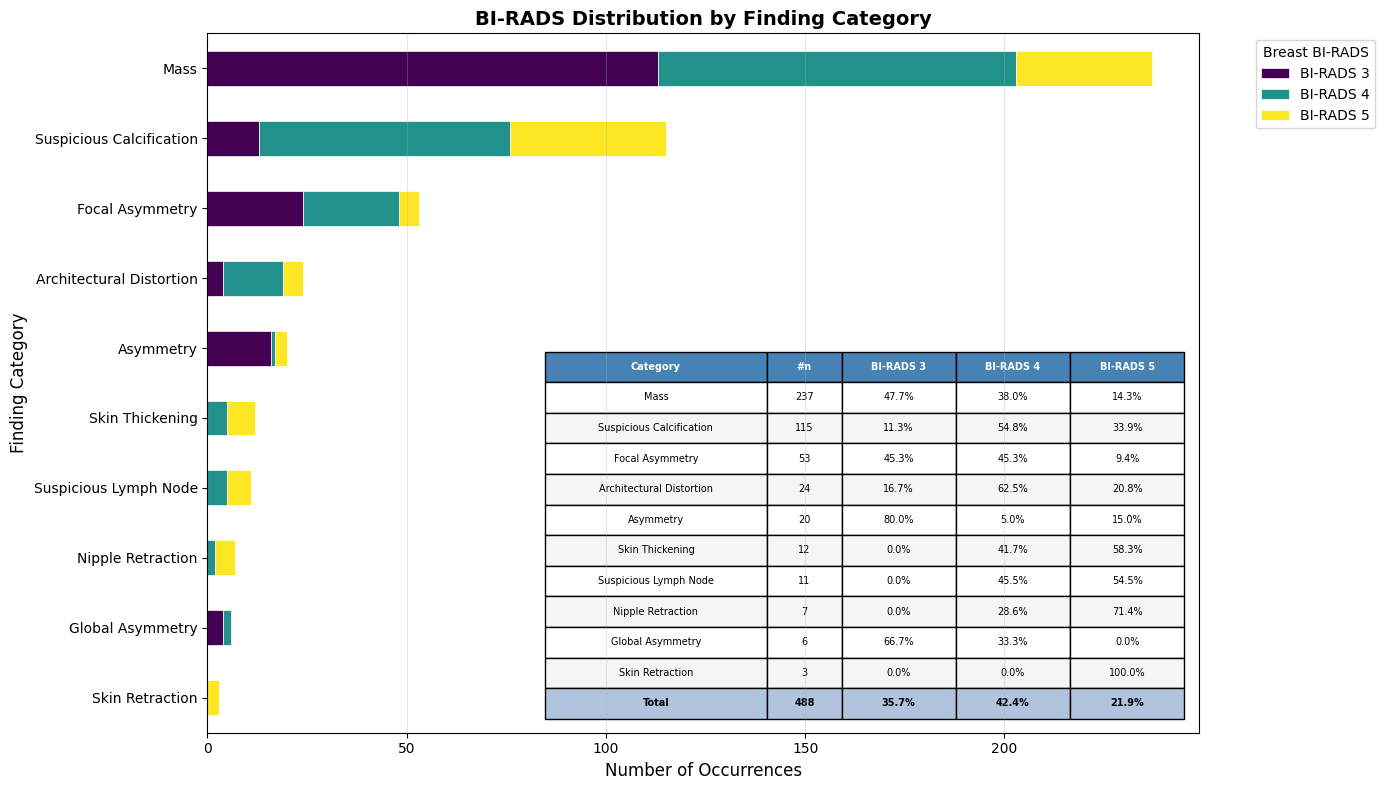

In [7]:
if 1:
    # Create a stacked bar chart showing BI-RADS distribution
    fig, ax = plt.subplots(figsize=(14, 8))

    # Get category counts for sorting
    category_counts = annot_test['finding_category'].value_counts().sort_values(ascending=True)

    # Stacked bar chart with BI-RADS distribution
    birads_counts = pd.crosstab(
        annot_test['finding_category'], 
        annot_test['breast_birads']
    )

    # Sort by total count
    birads_counts = birads_counts.loc[category_counts.index]

    birads_counts.plot(kind='barh', stacked=True, ax=ax, 
                    colormap='viridis', edgecolor='white', linewidth=0.5)
    ax.set_xlabel('Number of Occurrences', fontsize=12)
    ax.set_ylabel('Finding Category', fontsize=12)
    ax.set_title('BI-RADS Distribution by Finding Category', fontsize=14, fontweight='bold')
    ax.legend(title='Breast BI-RADS', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='x', alpha=0.3)

    # Create summary table
    birads_percentages = birads_counts.div(birads_counts.sum(axis=1), axis=0) * 100

    # Prepare table data - one total column and percentages for each BI-RADS
    table_data = []
    table_headers = ['Category', '#n']
    for birads in birads_counts.columns:
        table_headers.append(f'{birads}')

    for category in reversed(birads_counts.index):
        row = [category]  # Keep full category name
        total = birads_counts.loc[category].sum()
        row.append(f'{total}')
        for birads in birads_counts.columns:
            pct = birads_percentages.loc[category, birads]
            row.append(f'{pct:.1f}%')
        table_data.append(row)

    # Add a total row
    total_row = ['Total']
    grand_total = birads_counts.sum().sum()
    total_row.append(f'{grand_total}')
    for birads in birads_counts.columns:
        total_pct = (birads_counts[birads].sum() / grand_total) * 100
        total_row.append(f'{total_pct:.1f}%')
    table_data.append(total_row)

    # Add table to the plot
    table = ax.table(cellText=table_data, colLabels=table_headers,
                    cellLoc='center', loc='lower right',
                    bbox=[0.34, 0.02, 1.5*0.43, 1.5*0.35],  # [x, y, width, height]
                    cellColours=[['lightgray']*len(table_headers)]*len(table_data),
                    colColours=['steelblue']*len(table_headers))

    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1, 1.5)

    # Style the header and adjust column widths
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('steelblue')
        elif i == len(table_data):  # Total row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('lightsteelblue')
        else:
            cell.set_facecolor('whitesmoke' if i % 2 == 0 else 'white')
        
        # Make first column (Category) wider
        if j == 0:
            cell.set_width(0.39)
        elif j == 1:
            cell.set_width(0.13)
        else:
            cell.set_width(0.2)

    plt.tight_layout()
    plt.show()

# Predicted-class gradient heatmaps

Takes the mean of absolute values of gradients across the three channels that were backpropagated from logit score of the predicted class.

In [ ]:
def return_saliency_map(model, dataset, annot_row):
    
    dataloader_idx = np.where(dataset.patient_ids == annot_row['patient_id'])[0][0] + (1000 if annot_row['laterality'] == 'R' else 0)
    
    images_for_saliency, y1_label, y2_label = dataset[dataloader_idx]
    
    images_for_saliency = [item.unsqueeze(0).to('mps').requires_grad_() for item in images_for_saliency]
    model.to('mps')
    model.eval()
    
    output = model(images_for_saliency)
    predicted_class = output.argmax(dim=1)
    
    model.zero_grad()
    output[0, predicted_class].backward()
    saliency_maps = [img.grad.abs().mean(dim=1).squeeze().cpu().numpy() for img in images_for_saliency]
    
    saliency_map = saliency_maps[0] if annot_row['view'] == 'CC' else saliency_maps[1]
    
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    
    return saliency_map, predicted_class, y1_label, y2_label

def threshold_and_overlay(saliency_map, annot_row, percentile=None, prob_mass=0.9, method='prob_mass'):
    """
    Calculate IoU between thresholded saliency map and bounding box annotation.
    
    Parameters:
    -----------
    saliency_map : np.ndarray
        Normalized saliency map (should be in [0, 1] range)
    annot_row : pd.Series
        Annotation row containing bounding box coordinates (x_min, y_min, x_max, y_max)
    percentile : float, optional
        Percentile threshold for the saliency map (used if method='percentile')
    prob_mass : float
        Probability mass to keep (default: 0.9 = keep pixels containing 90% of total saliency)
    method : str
        'prob_mass' (default) - threshold to keep prob_mass of total saliency
        'percentile' - threshold at given percentile
    
    Returns:
    --------
    iou : float
        Intersection over Union between thresholded saliency and bounding box
    intersection : float
        Area of intersection
    union : float
        Area of union
    saliency_binary : np.ndarray
        Binary thresholded saliency map
    bbox_mask : np.ndarray
        Binary bounding box mask
    """
    # Get saliency map dimensions
    height, width = saliency_map.shape
    
    # Threshold the saliency map based on method
    if method == 'prob_mass':
        # Treat saliency as probability distribution
        # Normalize to sum to 1 (probability distribution)
        saliency_prob = saliency_map / saliency_map.sum()
        
        # Sort pixels by saliency value (descending)
        sorted_probs = np.sort(saliency_prob.flatten())[::-1]
        
        # Find cumulative sum
        cumsum = np.cumsum(sorted_probs)
        
        # Find threshold where cumulative mass reaches prob_mass
        n_pixels_to_keep = np.searchsorted(cumsum, prob_mass) + 1
        threshold_value = sorted_probs[n_pixels_to_keep - 1]
        
        # Create binary mask
        saliency_binary = saliency_prob >= threshold_value
        
    elif method == 'percentile':
        if percentile is None:
            percentile = 90
        threshold = np.percentile(saliency_map, percentile)
        saliency_binary = saliency_map > threshold
    else:
        raise ValueError(f"Unknown method: {method}. Use 'prob_mass' or 'percentile'")
    
    # Create bounding box mask
    bbox_mask = np.zeros((height, width), dtype=bool)
    
    # Extract bounding box coordinates and scale to image dimensions
    x_min = int(annot_row['resized_xmin'] * width / 912)
    y_min = int(annot_row['resized_ymin'] * height / 1520)
    x_max = int(annot_row['resized_xmax'] * width / 912)
    y_max = int(annot_row['resized_ymax'] * height / 1520)
    
    # Ensure coordinates are within bounds
    x_min = max(0, min(x_min, width - 1))
    x_max = max(0, min(x_max, width))
    y_min = max(0, min(y_min, height - 1))
    y_max = max(0, min(y_max, height))
    
    # Fill the bounding box mask
    bbox_mask[y_min:y_max, x_min:x_max] = True
    
    # Calculate intersection and union
    intersection = np.logical_and(saliency_binary, bbox_mask).sum()
    union = np.logical_or(saliency_binary, bbox_mask).sum()
    
    # Calculate IoU
    iou = intersection / union if union > 0 else 0.0
    
    return iou, intersection, union, saliency_binary, bbox_mask

def calculate_bbox_probability_mass(saliency_map, annot_row):
    """
    Calculate what fraction of total saliency (probability mass) falls within the bounding box.
    
    This is a threshold-free metric that directly measures how much attention 
    the model puts on the annotated region.
    
    Parameters:
    -----------
    saliency_map : np.ndarray
        Normalized saliency map (should be in [0, 1] range)
    annot_row : pd.Series
        Annotation row containing bounding box coordinates
    
    Returns:
    --------
    bbox_mass : float
        Fraction of total saliency mass within the bounding box [0, 1]
    bbox_mask : np.ndarray
        Binary bounding box mask
    mean_inside : float
        Average saliency inside the bbox
    mean_outside : float
        Average saliency outside the bbox
    mass_ratio : float
        Ratio of mean_inside / mean_outside (how much more attention inside vs outside)
    """
    height, width = saliency_map.shape
    
    # Normalize saliency to be a probability distribution (sum to 1)
    saliency_prob = saliency_map / saliency_map.sum()
    
    # Create bounding box mask
    bbox_mask = np.zeros((height, width), dtype=bool)
    
    # Extract and scale bounding box coordinates
    x_min = int(annot_row['resized_xmin'] * width / 912)
    y_min = int(annot_row['resized_ymin'] * height / 1520)
    x_max = int(annot_row['resized_xmax'] * width / 912)
    y_max = int(annot_row['resized_ymax'] * height / 1520)
    
    # Ensure coordinates are within bounds
    x_min = max(0, min(x_min, width - 1))
    x_max = max(0, min(x_max, width))
    y_min = max(0, min(y_min, height - 1))
    y_max = max(0, min(y_max, height))
    
    # Fill the bounding box mask
    bbox_mask[y_min:y_max, x_min:x_max] = True
    
    # Calculate probability mass within bbox
    bbox_mass = saliency_prob[bbox_mask].sum()
    
    # Calculate enrichment factor (how much more attention than expected by size alone)
    bbox_area = bbox_mask.sum()
    total_area = saliency_map.size
    expected_mass = bbox_area / total_area  # Expected mass if uniform distribution
    enrichment = bbox_mass / expected_mass if expected_mass > 0 else 0
    
    # Calculate additional metrics
    mean_inside = saliency_prob[bbox_mask].mean() if bbox_mask.sum() > 0 else 0
    mean_outside = saliency_prob[~bbox_mask].mean() if (~bbox_mask).sum() > 0 else 0
    mass_ratio = mean_inside / mean_outside if mean_outside > 0 else np.inf
    
    max_loc = np.unravel_index(saliency_map.argmax(), saliency_map.shape)    
    pointing_game = bbox_mask[max_loc]    

    return bbox_mask, enrichment, mean_inside, mean_outside, mass_ratio, pointing_game

def plot_probability_mass(model, dataset, annot_row):
    """
    Visualize probability mass analysis for a given annotation.
    
    Creates a 3-panel visualization showing:
    1. Normalized saliency map
    2. Probability distribution with bbox overlay
    3. Bbox region highlighted vs outside
    
    Parameters:
    -----------
    model : pytorch model
        The model to generate saliency from
    dataset : Dataset
        The dataset containing the images
    annot_row : pd.Series
        Annotation row containing patient_id, view, and bbox coordinates
    """
    # Generate saliency map
    saliency_map, predicted_class, y1_label, y2_label = return_saliency_map(model, dataset, annot_row)
    
    # Calculate metrics
    bbox_mask, enrichment, mean_inside, mean_outside, mass_ratio, pointing_game = calculate_bbox_probability_mass(
        saliency_map, annot_row
    )
    
    # Normalize to probability distribution for visualization
    saliency_prob = saliency_map / saliency_map.sum()
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Original saliency as heatmap
    im1 = axes[0].imshow(saliency_map, cmap='hot')
    axes[0].set_title('Normalized Saliency Map')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046)
    
    # 2. Probability distribution with bbox overlay
    im2 = axes[1].imshow(saliency_prob, cmap='hot')
    # Draw bbox rectangle
    y_min, y_max = np.where(bbox_mask)[0][[0, -1]]
    x_min, x_max = np.where(bbox_mask)[1][[0, -1]]
    rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                     linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--')
    axes[1].add_patch(rect)
    axes[1].set_title(f'Probability Distribution\nEnrichment: {enrichment:.2f}x (cyan bbox)')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046)
    
    # 3. Show bbox region vs outside
    overlay = np.zeros((*saliency_map.shape, 3))
    # Make bbox region show the actual saliency values
    overlay[bbox_mask] = plt.cm.hot(saliency_prob[bbox_mask] / saliency_prob.max())[:, :3]
    # Make outside region dimmed
    overlay[~bbox_mask] = plt.cm.gray(saliency_prob[~bbox_mask] / saliency_prob.max())[:, :3] * 0.3
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Bbox Region Highlighted\nMass-Ratio: {mass_ratio:.1f}x more attention')
    axes[2].axis('off')
    
    # Mark max saliency point
    max_loc = np.unravel_index(saliency_map.argmax(), saliency_map.shape)
    max_y, max_x = max_loc
    for ax in axes:
        ax.plot(max_x, max_y, 'g*', markersize=15, markeredgecolor='white', markeredgewidth=1)
    
    fig.suptitle(f'Probability Mass Analysis (No Thresholding)\nAnnotation class: {annot_row["finding_category"]}, BI-RADS: {y1_label}, Density: {y2_label}, Predicted Class: {predicted_class.item()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return enrichment, mass_ratio, pointing_game

def process_all_annotations(model, dataset, annot_df):
    results = []
    for idx, row in tqdm(annot_df.iterrows(), total=len(annot_df), desc="Processing annotations"):
        saliency_map, predicted_class, y1_label, y2_label = return_saliency_map(model, dataset, row)
        
        # Calculate probability mass metrics
        bbox_mask, enrichment, mean_inside, mean_outside, mass_ratio, pointing_game = calculate_bbox_probability_mass(
            saliency_map, row
        )
        
        results.append({
            'patient_id': row['patient_id'],
            'breast_id': row['series_id'],
            'view': row['view'],
            'laterality': row['laterality'],
            'finding_category': row['finding_category'],
            'enrichment': enrichment,
            'mean_inside': mean_inside,
            'mean_outside': mean_outside,
            'mass_ratio': mass_ratio,
            'pointing_game': pointing_game,
            'BI-RADS': y1_label.item(),
            'Density': y2_label.item(),
            'predicted_class': predicted_class.item(),
            'bbox_mask': bbox_mask

        })
    
    results_df = pd.DataFrame(results)
    return results_df





In [9]:
saliency_map, predicted_class, y1_label, y2_label = return_saliency_map(model, breast_loader.test_dataset, annot_test.iloc[5])
iou, intersection, union, saliency_binary, bbox_mask = threshold_and_overlay(saliency_map, annot_test.iloc[5], percentile=90)
iou


np.float64(0.20502470401789877)

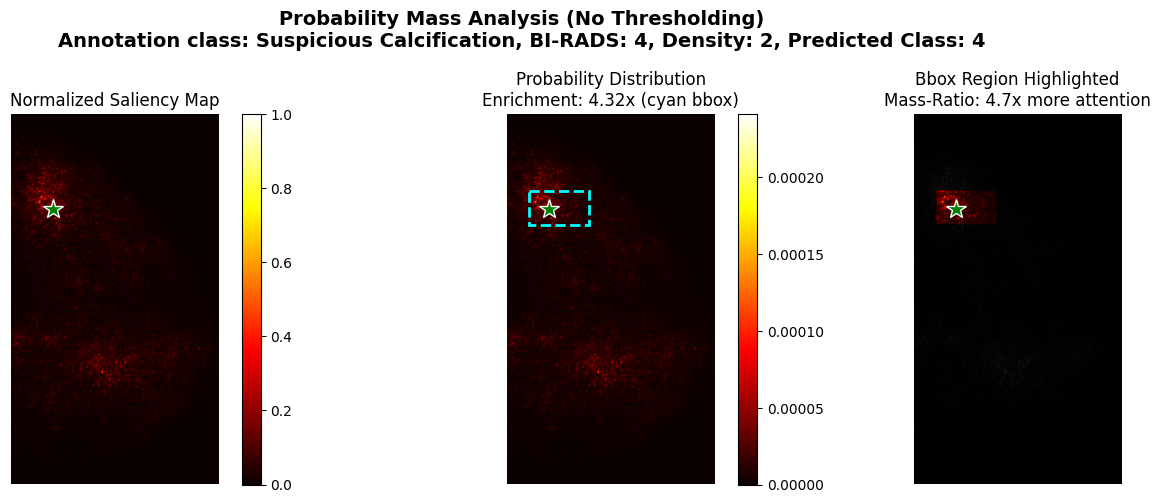

(np.float64(4.322078332165691), np.float32(4.7492495), np.True_)

In [41]:
plot_probability_mass(model, breast_loader.test_dataset, annot_test.iloc[10])

In [12]:
results = process_all_annotations(model, breast_loader.test_dataset, annot_test)
results

Processing annotations:   0%|          | 0/488 [00:00<?, ?it/s]

,patient_id,breast_id,view,laterality,finding_category,enrichment,mean_inside,mean_outside,mass_ratio,pointing_game,BI-RADS,Density,predicted_class
0,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,CC,L,Mass,2.425272,0.000010,0.000004,2.538824,False,2,2,3
1,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,MLO,L,Mass,1.829111,0.000008,0.000004,1.863125,False,2,2,3
2,917a4de3b1f921f1c9fa98b7a61d749d,22bada39b619f79a660b3a06eb6ff5a9,CC,L,Mass,2.249593,0.000009,0.000004,2.485333,False,2,2,1
3,917a4de3b1f921f1c9fa98b7a61d749d,22bada39b619f79a660b3a06eb6ff5a9,MLO,L,Mass,5.451933,0.000022,0.000004,6.381196,True,2,2,1
4,31fa226bc9f87e0a2cb2de6dddbc2270,98ca3b2d3a802a417d2942bc5f0fc036,MLO,L,Mass,1.542053,0.000006,0.000004,1.549725,False,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,CC,R,Mass,2.387935,0.000010,0.000004,2.441063,False,3,2,3
484,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,MLO,R,Suspicious Lymph Node,7.805503,0.000032,0.000004,8.012268,False,3,2,3
485,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,MLO,R,Mass,6.372867,0.000026,0.000004,6.671780,True,3,2,3
486,b8acac150be7f949f78dc631a3851f8b,f351166fe105bea6f090e38f41bc844c,MLO,R,Mass,3.983850,0.000016,0.000004,4.518960,False,3,2,3


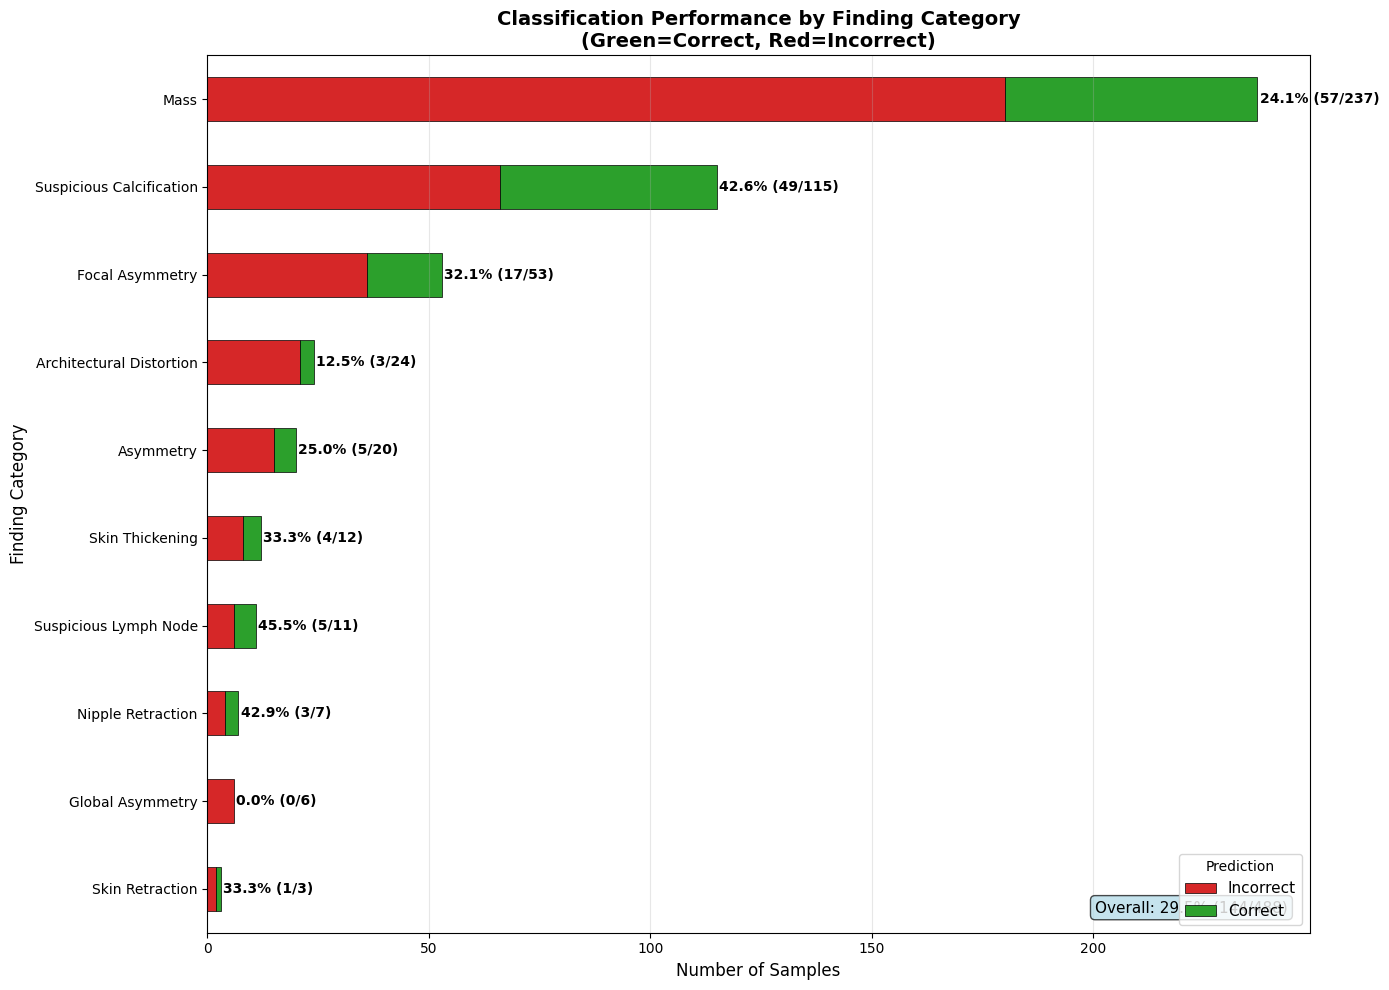

In [13]:
if 1:
    # Visualize classification performance stratified by finding category
    results['correct'] = (results['BI-RADS'] == results['predicted_class']).astype(int)
    accuracy_by_category = results.groupby('finding_category').agg({
        'correct': ['mean', 'sum', 'count']
    }).round(3)
    accuracy_by_category.columns = ['Accuracy', 'Correct', 'Total']
    accuracy_by_category = accuracy_by_category.sort_values('Total', ascending=True)

    # Create single comprehensive figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Stacked bar showing correct/incorrect per category
    category_counts = results.groupby(['finding_category', 'correct']).size().unstack(fill_value=0)
    category_counts = category_counts.loc[accuracy_by_category.index]  # Same order as accuracy
    category_counts.plot(kind='barh', stacked=True, ax=ax, color=['#d62728', '#2ca02c'], 
                        edgecolor='black', linewidth=0.5)

    # Add accuracy percentages and ratios as text labels
    for i, (cat, row) in enumerate(accuracy_by_category.iterrows()):
        total = category_counts.loc[cat].sum()
        # Position text at the end of the bar
        ax.text(total + 0.5, i, f"{row['Accuracy']:.1%} ({int(row['Correct'])}/{int(row['Total'])})", 
                va='center', fontsize=10, fontweight='bold')

    ax.set_xlabel('Number of Samples', fontsize=12)
    ax.set_ylabel('Finding Category', fontsize=12)
    ax.set_title('Classification Performance by Finding Category\n(Green=Correct, Red=Incorrect)', 
                fontsize=14, fontweight='bold')
    ax.legend(['Incorrect', 'Correct'], title='Prediction', loc='lower right', fontsize=11)
    ax.grid(axis='x', alpha=0.3)

    # Add overall statistics as text box
    overall_acc = results['correct'].mean()
    overall_n = len(results)
    overall_correct = results['correct'].sum()
    stats_text = f"Overall: {overall_acc:.1%} ({int(overall_correct)}/{overall_n})"
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7, edgecolor='black'))

    plt.tight_layout()
    plt.show()


plotting the gradient heatmap overlap with BB metrics for all the annotated data

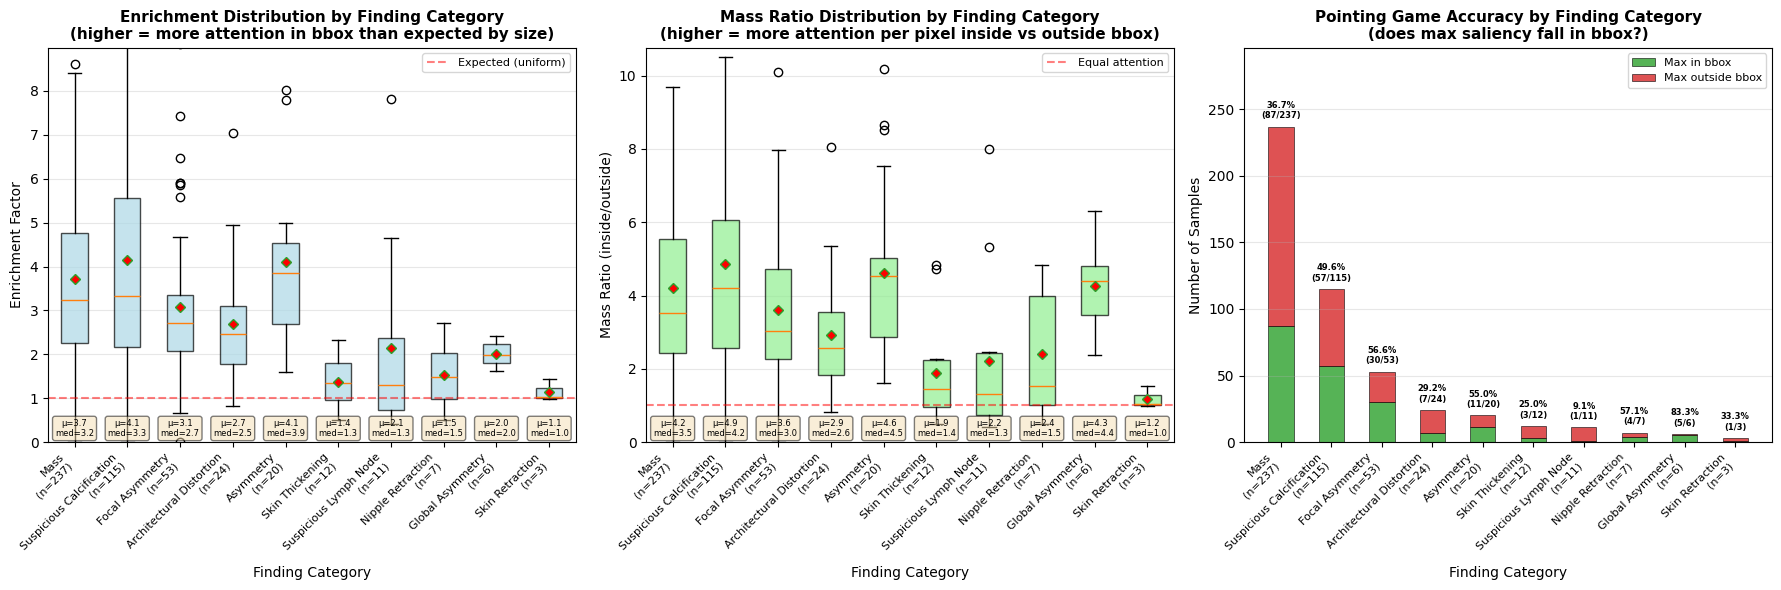

In [28]:
if 1:
    # Create comprehensive visualization of saliency metrics by finding category
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Sort categories by total count for consistent ordering
    category_order = results['finding_category'].value_counts(ascending=False).index
    
    # Create labels with sample counts
    category_labels = [f"{cat}\n(n={len(results[results['finding_category'] == cat])})" 
                      for cat in category_order]
    
    # 1. Enrichment distribution
    ax = axes[0]
    enrichment_data = [results[results['finding_category'] == cat]['enrichment'].values 
                       for cat in category_order]
    bp1 = ax.boxplot(enrichment_data, tick_labels=category_labels, 
                     patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                     widths=0.5)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Enrichment Distribution by Finding Category\n(higher = more attention in bbox than expected by size)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected (uniform)')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
    
    # Set reasonable y-axis limits
    max_enrichment = results['enrichment'].quantile(0.95)
    ax.set_ylim(0, max_enrichment * 1.15)
    
    # Add median values as text at bottom
    for i, cat in enumerate(category_order):
        median_val = results[results['finding_category'] == cat]['enrichment'].median()
        mean_val = results[results['finding_category'] == cat]['enrichment'].mean()
        y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
        ax.text(i + 1, y_pos, f'μ={mean_val:.1f}\nmed={median_val:.1f}', 
               va='bottom', ha='center', fontsize=6, bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.5))
    
    # 2. Mass ratio distribution
    ax = axes[1]
    mass_ratio_data = [results[results['finding_category'] == cat]['mass_ratio'].values 
                       for cat in category_order]
    bp2 = ax.boxplot(mass_ratio_data, tick_labels=category_labels,
                     patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                     widths=0.5)
    for patch in bp2['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Mass Ratio Distribution by Finding Category\n(higher = more attention per pixel inside vs outside bbox)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal attention')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
    
    # Set reasonable y-axis limits
    max_mass_ratio = results['mass_ratio'].quantile(0.95)
    ax.set_ylim(0, max_mass_ratio * 1.15)
    
    # Add median values as text at bottom
    for i, cat in enumerate(category_order):
        median_val = results[results['finding_category'] == cat]['mass_ratio'].median()
        mean_val = results[results['finding_category'] == cat]['mass_ratio'].mean()
        y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
        ax.text(i + 1, y_pos, f'μ={mean_val:.1f}\nmed={median_val:.1f}', 
               va='bottom', ha='center', fontsize=6, bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.5))
    
    # 3. Pointing Game accuracy (bar chart with percentages)
    ax = axes[2]
    pointing_stats = results.groupby('finding_category')['pointing_game'].agg(['mean', 'sum', 'count'])
    pointing_stats = pointing_stats.loc[category_order]
    
    # Create stacked bar chart
    success = pointing_stats['sum'].values
    failure = pointing_stats['count'].values - success
    
    x_pos = np.arange(len(category_order))
    ax.bar(x_pos, success, width=0.5, color='#2ca02c', alpha=0.8, label='Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos, failure, width=0.5, bottom=success, color='#d62728', alpha=0.8, label='Max outside bbox', edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Pointing Game Accuracy by Finding Category\n(does max saliency fall in bbox?)', 
                fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_count = pointing_stats['count'].max()
    ax.set_ylim(0, max_count * 1.25)
    
    # Add percentage labels on top of bars
    for i, cat in enumerate(category_order):
        total = pointing_stats.loc[cat, 'count']
        acc = pointing_stats.loc[cat, 'mean']
        ax.text(i, total + max_count * 0.02, f"{acc:.1%}\n({int(pointing_stats.loc[cat, 'sum'])}/{int(total)})", 
               ha='center', va='bottom', fontsize=6, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    

plotting the gradient heatmap overlap with BB metrics just for the samples where the model correctly predicted the birads label

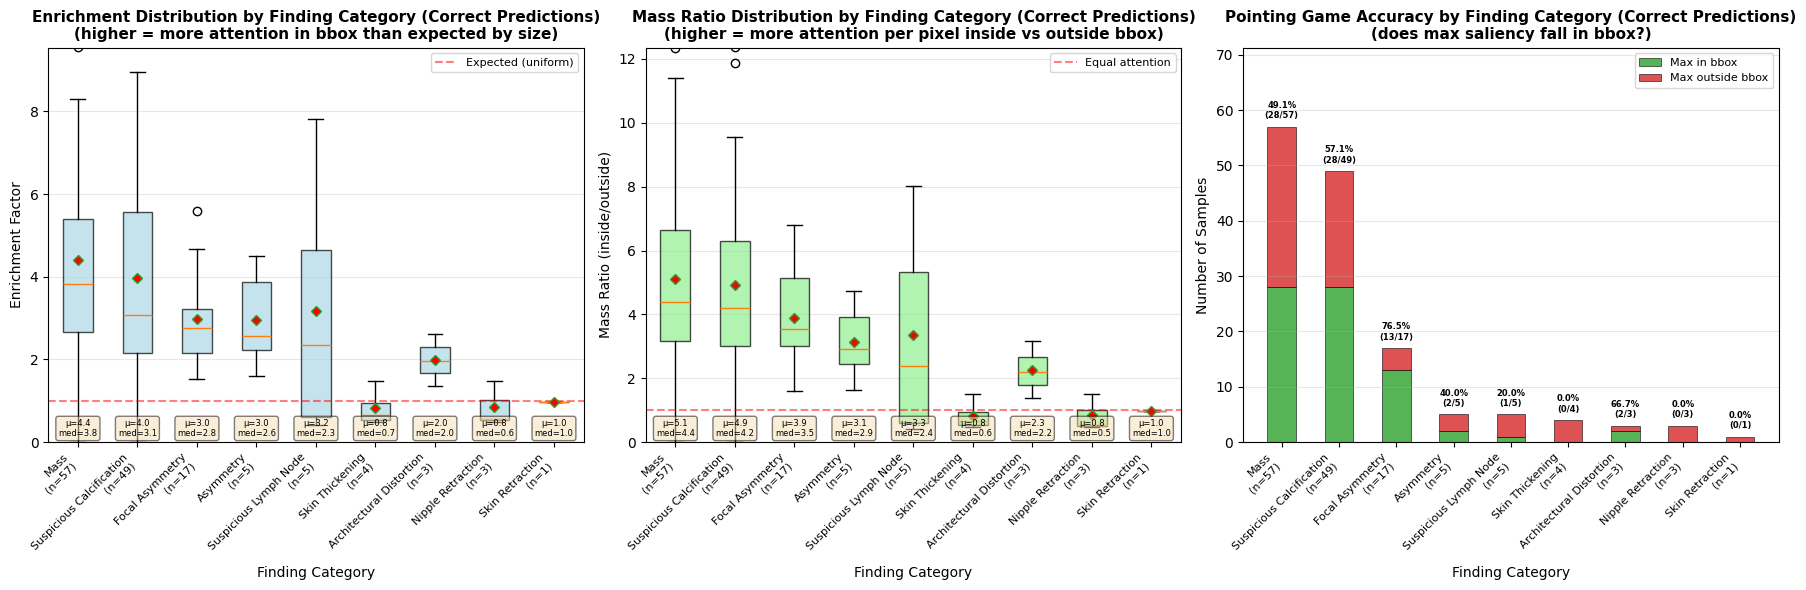

In [32]:
if 1:
    # Filter for correctly predicted samples only
    results_correct = results[results['BI-RADS'] == results['predicted_class']].copy()
    
    # Create comprehensive visualization of saliency metrics by finding category (CORRECT PREDICTIONS ONLY)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Sort categories by total count for consistent ordering
    category_order = results_correct['finding_category'].value_counts(ascending=False).index
    
    # Create labels with sample counts
    category_labels = [f"{cat}\n(n={len(results_correct[results_correct['finding_category'] == cat])})" 
                      for cat in category_order]
    
    # 1. Enrichment distribution
    ax = axes[0]
    enrichment_data = [results_correct[results_correct['finding_category'] == cat]['enrichment'].values 
                       for cat in category_order]
    bp1 = ax.boxplot(enrichment_data, tick_labels=category_labels, 
                     patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                     widths=0.5)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Enrichment Distribution by Finding Category (Correct Predictions)\n(higher = more attention in bbox than expected by size)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected (uniform)')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
    
    # Set reasonable y-axis limits
    max_enrichment = results_correct['enrichment'].quantile(0.95)
    ax.set_ylim(0, max_enrichment * 1.15)
    
    # Add median values as text at bottom
    for i, cat in enumerate(category_order):
        median_val = results_correct[results_correct['finding_category'] == cat]['enrichment'].median()
        mean_val = results_correct[results_correct['finding_category'] == cat]['enrichment'].mean()
        y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
        ax.text(i + 1, y_pos, f'μ={mean_val:.1f}\nmed={median_val:.1f}', 
               va='bottom', ha='center', fontsize=6, bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.5))
    
    # 2. Mass ratio distribution
    ax = axes[1]
    mass_ratio_data = [results_correct[results_correct['finding_category'] == cat]['mass_ratio'].values 
                       for cat in category_order]
    bp2 = ax.boxplot(mass_ratio_data, tick_labels=category_labels,
                     patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                     widths=0.5)
    for patch in bp2['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Mass Ratio Distribution by Finding Category (Correct Predictions)\n(higher = more attention per pixel inside vs outside bbox)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal attention')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
    
    # Set reasonable y-axis limits
    max_mass_ratio = results_correct['mass_ratio'].quantile(0.95)
    ax.set_ylim(0, max_mass_ratio * 1.15)
    
    # Add median values as text at bottom
    for i, cat in enumerate(category_order):
        median_val = results_correct[results_correct['finding_category'] == cat]['mass_ratio'].median()
        mean_val = results_correct[results_correct['finding_category'] == cat]['mass_ratio'].mean()
        y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
        ax.text(i + 1, y_pos, f'μ={mean_val:.1f}\nmed={median_val:.1f}', 
               va='bottom', ha='center', fontsize=6, bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.5))
    
    # 3. Pointing Game accuracy (bar chart with percentages)
    ax = axes[2]
    pointing_stats = results_correct.groupby('finding_category')['pointing_game'].agg(['mean', 'sum', 'count'])
    pointing_stats = pointing_stats.loc[category_order]
    
    # Create stacked bar chart
    success = pointing_stats['sum'].values
    failure = pointing_stats['count'].values - success
    
    x_pos = np.arange(len(category_order))
    ax.bar(x_pos, success, width=0.5, color='#2ca02c', alpha=0.8, label='Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos, failure, width=0.5, bottom=success, color='#d62728', alpha=0.8, label='Max outside bbox', edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Pointing Game Accuracy by Finding Category (Correct Predictions)\n(does max saliency fall in bbox?)', 
                fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_count = pointing_stats['count'].max()
    ax.set_ylim(0, max_count * 1.25)
    
    # Add percentage labels on top of bars
    for i, cat in enumerate(category_order):
        total = pointing_stats.loc[cat, 'count']
        acc = pointing_stats.loc[cat, 'mean']
        ax.text(i, total + max_count * 0.02, f"{acc:.1%}\n({int(pointing_stats.loc[cat, 'sum'])}/{int(total)})", 
               ha='center', va='bottom', fontsize=6, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    


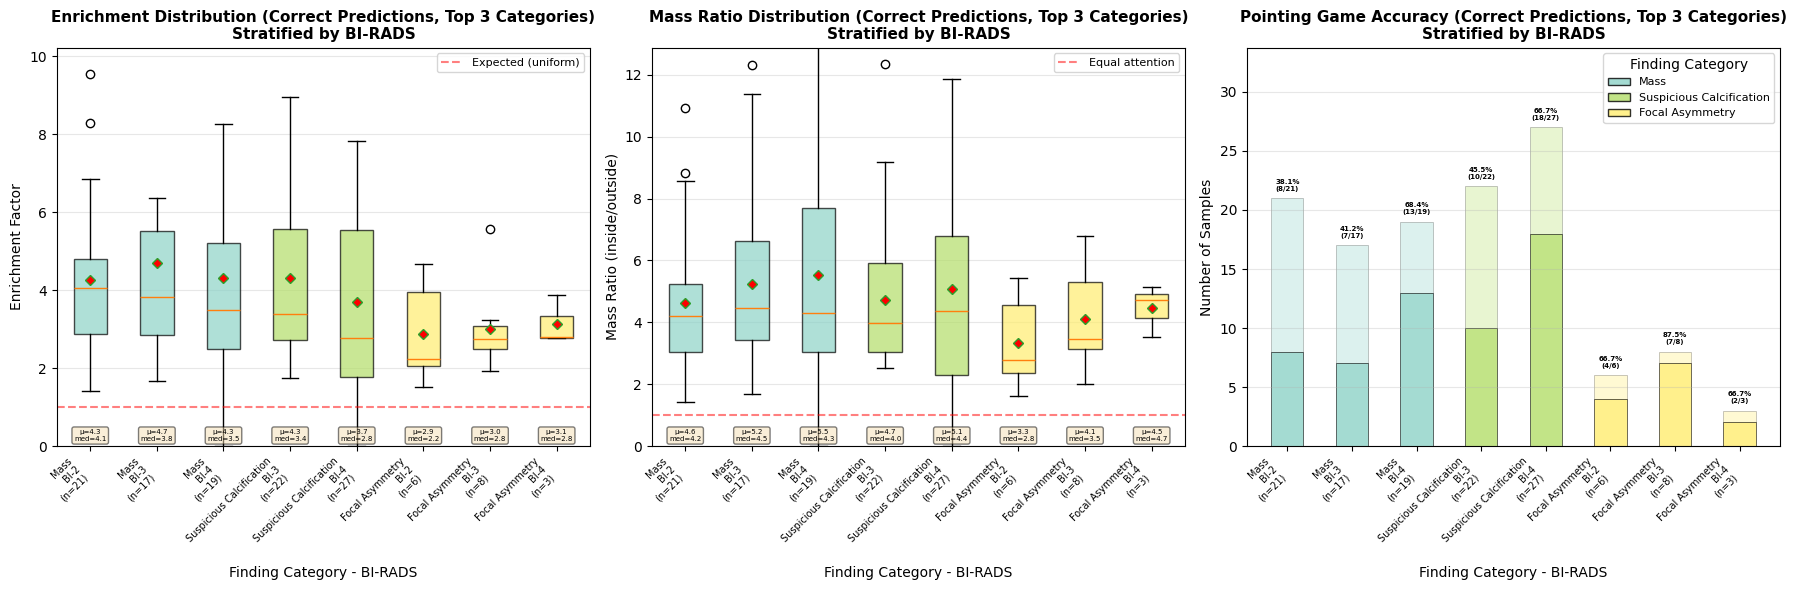

In [36]:
if 1:
    # Filter for correctly predicted samples
    results_correct = results[results['BI-RADS'] == results['predicted_class']].copy()
    
    # Get top 3 finding categories by sample count
    top_3_categories = results_correct['finding_category'].value_counts().head(3).index.tolist()
    results_correct_top3 = results_correct[results_correct['finding_category'].isin(top_3_categories)]
    
    # Get all BI-RADS values present in this filtered data
    birads_values = sorted(results_correct_top3['BI-RADS'].unique())
    
    # Create color palette for categories
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_3_categories)))
    category_colors = {cat: colors[i] for i, cat in enumerate(top_3_categories)}
    
    # Create comprehensive visualization stratified by BI-RADS
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create x-axis labels combining category and BI-RADS
    # Structure: [Cat1-BIRADS1, Cat1-BIRADS2, ..., Cat2-BIRADS1, Cat2-BIRADS2, ...]
    categories_and_birads = []
    enrichment_data_stratified = []
    mass_ratio_data_stratified = []
    pointing_game_data_stratified = []
    box_category_mapping = []  # Track which category each box corresponds to
    
    for cat in top_3_categories:
        for birads in birads_values:
            subset = results_correct_top3[(results_correct_top3['finding_category'] == cat) & 
                                         (results_correct_top3['BI-RADS'] == birads)]
            if len(subset) > 0:
                categories_and_birads.append(f"{cat}\nBI-{birads}\n(n={len(subset)})")
                enrichment_data_stratified.append(subset['enrichment'].values)
                mass_ratio_data_stratified.append(subset['mass_ratio'].values)
                pointing_game_data_stratified.append(subset['pointing_game'].values)
                box_category_mapping.append(cat)
    
    # 1. Enrichment distribution
    ax = axes[0]
    bp1 = ax.boxplot(enrichment_data_stratified, tick_labels=categories_and_birads, 
                     patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                     widths=0.5)
    # Color the boxes by category
    for patch, cat in zip(bp1['boxes'], box_category_mapping):
        patch.set_facecolor(category_colors[cat])
        patch.set_alpha(0.7)
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_xlabel('Finding Category - BI-RADS', fontsize=10)
    ax.set_title('Enrichment Distribution (Correct Predictions, Top 3 Categories)\nStratified by BI-RADS', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected (uniform)')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=7)
    
    # Set reasonable y-axis limits
    max_enrichment = results_correct_top3['enrichment'].quantile(0.95)
    ax.set_ylim(0, max_enrichment * 1.15)
    
    # Add median values as text at bottom
    for i, data in enumerate(enrichment_data_stratified):
        if len(data) > 0:
            median_val = np.median(data)
            mean_val = np.mean(data)
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
            ax.text(i + 1, y_pos, f'μ={mean_val:.1f}\nmed={median_val:.1f}', 
                   va='bottom', ha='center', fontsize=5, bbox=dict(boxstyle='round', 
                   facecolor='wheat', alpha=0.5))
    
    # 2. Mass ratio distribution
    ax = axes[1]
    bp2 = ax.boxplot(mass_ratio_data_stratified, tick_labels=categories_and_birads,
                     patch_artist=True, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                     widths=0.5)
    # Color the boxes by category
    for patch, cat in zip(bp2['boxes'], box_category_mapping):
        patch.set_facecolor(category_colors[cat])
        patch.set_alpha(0.7)
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_xlabel('Finding Category - BI-RADS', fontsize=10)
    ax.set_title('Mass Ratio Distribution (Correct Predictions, Top 3 Categories)\nStratified by BI-RADS', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal attention')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=7)
    
    # Set reasonable y-axis limits
    max_mass_ratio = results_correct_top3['mass_ratio'].quantile(0.95)
    ax.set_ylim(0, max_mass_ratio * 1.15)
    
    # Add median values as text at bottom
    for i, data in enumerate(mass_ratio_data_stratified):
        if len(data) > 0:
            median_val = np.median(data)
            mean_val = np.mean(data)
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01
            ax.text(i + 1, y_pos, f'μ={mean_val:.1f}\nmed={median_val:.1f}', 
                   va='bottom', ha='center', fontsize=5, bbox=dict(boxstyle='round', 
                   facecolor='wheat', alpha=0.5))
    
    # 3. Pointing Game accuracy (bar chart with percentages)
    ax = axes[2]
    success_counts = []
    total_counts = []
    
    for data in pointing_game_data_stratified:
        success_counts.append(np.sum(data))
        total_counts.append(len(data))
    
    failure_counts = [total - success for total, success in zip(total_counts, success_counts)]
    
    x_pos = np.arange(len(categories_and_birads))
    # Color bars by category
    bar_colors = [category_colors[cat] for cat in box_category_mapping]
    ax.bar(x_pos, success_counts, width=0.5, color=bar_colors, alpha=0.8, label='Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos, failure_counts, width=0.5, bottom=success_counts, color=bar_colors, alpha=0.3, edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories_and_birads, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_xlabel('Finding Category - BI-RADS', fontsize=10)
    ax.set_title('Pointing Game Accuracy (Correct Predictions, Top 3 Categories)\nStratified by BI-RADS', 
                fontsize=11, fontweight='bold')
    
    # Create custom legend for categories
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=category_colors[cat], alpha=0.8, edgecolor='black', label=cat)
                       for cat in top_3_categories]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, title='Finding Category')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_count = max(total_counts)
    ax.set_ylim(0, max_count * 1.25)
    
    # Add percentage labels on top of bars
    for i, (success, total) in enumerate(zip(success_counts, total_counts)):
        if total > 0:
            acc = success / total
            ax.text(i, total + max_count * 0.02, f"{acc:.1%}\n({int(success)}/{int(total)})", 
                   ha='center', va='bottom', fontsize=5, fontweight='bold')
    
    plt.tight_layout()
    plt.show()



# AJIVE driven gradient heatmaps: cancer vs density
Effectively calculating the first score of selected Indiv/Joint component using the corresponding loadings vector, then creating gradient maps for this score. - Parts of the image that most affect the value of the score.

In [44]:
test_data = torch.load('saved_features/CANCvsDENS/all_data_test.pt')
test_cancer_features = test_data['cancer_features'].numpy()
test_cancer_labels = test_data['cancer_labels'].numpy()
test_cancer_logits = test_data['cancer_logits'].numpy()
test_dens_features = test_data['dens_features'].numpy()
test_dens_labels = test_data['dens_labels'].numpy()
test_dens_logits = test_data['dens_logits'].numpy()

In [48]:
ajive = AJIVE(init_signal_ranks=[12,19], n_jobs=16, center=True)
ajive.fit([test_cancer_features, test_dens_features])
ajive.summary()

'AJIVE, joint rank: 2, view 0 indiv rank: 10, view 1 indiv rank: 17'

In [49]:
cancer_individual_first_loadings = ajive.view_specific_[0].individual_.loadings_[:,0]
dens_individual_first_loadings = ajive.view_specific_[1].individual_.loadings_[:,0]

In [94]:
def return_ajive_saliency_map(model, dataset, annot_row, loadings_vector):
    
    dataloader_idx = np.where(dataset.patient_ids == annot_row['patient_id'])[0][0] + (1000 if annot_row['laterality'] == 'R' else 0)
    
    images_for_saliency, y1_label, y2_label = dataset[dataloader_idx]
    
    images_for_saliency = [item.unsqueeze(0).to('mps').requires_grad_() for item in images_for_saliency]
    model.to('mps')
    model.eval()
    
    intermediate_features = torch.cat([model.resnets[i](images_for_saliency[i]) for i in range(2)], dim=1)
    
    loadings_vector_tensor = torch.tensor(loadings_vector, dtype=torch.float32).to('mps')
    if loadings_vector_tensor.ndim == 1:
        loadings_vector_tensor = loadings_vector_tensor.unsqueeze(0)
        
    if loadings_vector_tensor.shape[1] != intermediate_features.shape[1]:
        raise ValueError(f"Loadings vector dimension ({loadings_vector_tensor.shape[1]}) does not match model feature dimension ({intermediate_features.shape[1]}).")
    
    weighted_features = (intermediate_features * loadings_vector_tensor).sum()
    if weighted_features.numel() != 1:
        raise ValueError(f"The weighted features did not reduce to a single scalar value. Got shape: {weighted_features.shape}")
    
    model.zero_grad()
    for img in images_for_saliency:
        img.grad = None  # Clear previous gradients if any
    
    weighted_features.backward()
    
    saliency_maps = [img.grad.abs().mean(dim=1).squeeze().cpu().numpy() for img in images_for_saliency]
    
    saliency_map = saliency_maps[0] if annot_row['view'] == 'CC' else saliency_maps[1]
    
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    predicted_class = torch.argmax(model.fc(intermediate_features), dim=1)
    
    return saliency_map, predicted_class, y1_label, y2_label, weighted_features

def process_all_annotations_ajive(model, dataset, annot_df, loadings_vector):
    results = []
    for idx, row in tqdm(annot_df.iterrows(), total=len(annot_df), desc="Processing annotations"):
        saliency_map, predicted_class, y1_label, y2_label, ajive_score = return_ajive_saliency_map(model, dataset, row, loadings_vector)
        
        # Calculate probability mass metrics
        bbox_mask, enrichment, mean_inside, mean_outside, mass_ratio, pointing_game = calculate_bbox_probability_mass(
            saliency_map, row
        )
        
        results.append({
            'patient_id': row['patient_id'],
            'breast_id': row['series_id'],
            'view': row['view'],
            'laterality': row['laterality'],
            'finding_category': row['finding_category'],
            'enrichment': enrichment,
            'mean_inside': mean_inside,
            'mean_outside': mean_outside,
            'mass_ratio': mass_ratio,
            'pointing_game': pointing_game,
            'BI-RADS': y1_label.item(),
            'Density': y2_label.item(),
            'predicted_class': predicted_class.item(),
            'bbox_mask': bbox_mask,
            'ajive_score': ajive_score.item()
        })
    
    results_df = pd.DataFrame(results)
    return results_df


def plot_probability_mass_ajive(model, dataset, annot_row, loadings_vector):
    """
    Visualize probability mass analysis for a given annotation.
    
    Creates a 3-panel visualization showing:
    1. Normalized saliency map
    2. Probability distribution with bbox overlay
    3. Bbox region highlighted vs outside
    
    Parameters:
    -----------
    model : pytorch model
        The model to generate saliency from
    dataset : Dataset
        The dataset containing the images
    annot_row : pd.Series
        Annotation row containing patient_id, view, and bbox coordinates
    """
    # Generate saliency map
    saliency_map, predicted_class, y1_label, y2_label, ajive_score = return_ajive_saliency_map(model, dataset, annot_row, loadings_vector)
    
    # Calculate metrics
    bbox_mask, enrichment, mean_inside, mean_outside, mass_ratio, pointing_game = calculate_bbox_probability_mass(
        saliency_map, annot_row
    )
    
    # Normalize to probability distribution for visualization
    saliency_prob = saliency_map / saliency_map.sum()
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Original saliency as heatmap
    im1 = axes[0].imshow(saliency_map, cmap='hot')
    axes[0].set_title('Normalized Saliency Map')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046)
    
    # 2. Probability distribution with bbox overlay
    im2 = axes[1].imshow(saliency_prob, cmap='hot')
    # Draw bbox rectangle
    y_min, y_max = np.where(bbox_mask)[0][[0, -1]]
    x_min, x_max = np.where(bbox_mask)[1][[0, -1]]
    rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                     linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--')
    axes[1].add_patch(rect)
    axes[1].set_title(f'Probability Distribution\nEnrichment: {enrichment:.2f}x (cyan bbox)')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046)
    
    # 3. Show bbox region vs outside
    overlay = np.zeros((*saliency_map.shape, 3))
    # Make bbox region show the actual saliency values
    overlay[bbox_mask] = plt.cm.hot(saliency_prob[bbox_mask] / saliency_prob.max())[:, :3]
    # Make outside region dimmed
    overlay[~bbox_mask] = plt.cm.gray(saliency_prob[~bbox_mask] / saliency_prob.max())[:, :3] * 0.3
    
    axes[2].imshow(overlay)
    axes[2].set_title(f'Bbox Region Highlighted\nMass-Ratio: {mass_ratio:.1f}x more attention')
    axes[2].axis('off')
    
    # Mark max saliency point
    max_loc = np.unravel_index(saliency_map.argmax(), saliency_map.shape)
    max_y, max_x = max_loc
    for ax in axes:
        ax.plot(max_x, max_y, 'g*', markersize=15, markeredgecolor='white', markeredgewidth=1)
    
    fig.suptitle(f'Probability Mass Analysis (No Thresholding)\nAnnotation class: {annot_row["finding_category"]}, BI-RADS: {y1_label}, Density: {y2_label}, Predicted Class: {predicted_class.item()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return enrichment, mass_ratio, pointing_game

def plot_probability_mass_comparison(model1, model2, dataset, annot_row, loadings_vector1, loadings_vector2):
    """
    Compare probability mass analysis between two models for a given annotation.
    
    Creates a 2x3 visualization showing the three-panel analysis (normalized saliency, 
    probability distribution with bbox, and bbox region highlighted) for both models.
    
    Parameters:
    -----------
    model1 : pytorch model
        The first model to generate saliency from
    model2 : pytorch model
        The second model to generate saliency from
    dataset : Dataset
        The dataset containing the images
    annot_row : pd.Series
        Annotation row containing patient_id, view, and bbox coordinates
    loadings_vector1 : np.ndarray or torch.Tensor
        Loading vector for model 1
    loadings_vector2 : np.ndarray or torch.Tensor
        Loading vector for model 2
    """
    # Generate saliency maps
    saliency_map1, predicted_class1, y1_label, y2_label, _ = return_ajive_saliency_map(model1, dataset, annot_row, loadings_vector1)
    saliency_map2, predicted_class2, _, _, _ = return_ajive_saliency_map(model2, dataset, annot_row, loadings_vector2)
    
    # Calculate metrics for model 1
    bbox_mask1, enrichment1, mean_inside1, mean_outside1, mass_ratio1, pointing_game1 = calculate_bbox_probability_mass(
        saliency_map1, annot_row
    )
    
    # Calculate metrics for model 2
    bbox_mask2, enrichment2, mean_inside2, mean_outside2, mass_ratio2, pointing_game2 = calculate_bbox_probability_mass(
        saliency_map2, annot_row
    )
    
    # Normalize to probability distributions
    saliency_prob1 = saliency_map1 / saliency_map1.sum()
    saliency_prob2 = saliency_map2 / saliency_map2.sum()
    
    # Create figure with 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # ==================== MODEL 1 (Top Row) ====================
    
    # 1. Model 1 - Normalized saliency map
    im1 = axes[0, 0].imshow(saliency_map1, cmap='hot')
    axes[0, 0].set_title('Model 1: Normalized Saliency Map', fontweight='bold')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
    
    # 2. Model 1 - Probability distribution with bbox overlay
    im2 = axes[0, 1].imshow(saliency_prob1, cmap='hot')
    y_min1, y_max1 = np.where(bbox_mask1)[0][[0, -1]]
    x_min1, x_max1 = np.where(bbox_mask1)[1][[0, -1]]
    rect1 = Rectangle((x_min1, y_min1), x_max1-x_min1, y_max1-y_min1, 
                      linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--')
    axes[0, 1].add_patch(rect1)
    axes[0, 1].set_title(f'Model 1: Probability Distribution\nEnrichment: {enrichment1:.2f}x (cyan bbox)', fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    
    # 3. Model 1 - Bbox region highlighted vs outside
    overlay1 = np.zeros((*saliency_map1.shape, 3))
    overlay1[bbox_mask1] = plt.cm.hot(saliency_prob1[bbox_mask1] / saliency_prob1.max())[:, :3]
    overlay1[~bbox_mask1] = plt.cm.gray(saliency_prob1[~bbox_mask1] / saliency_prob1.max())[:, :3] * 0.3
    axes[0, 2].imshow(overlay1)
    axes[0, 2].set_title(f'Model 1: Bbox Region Highlighted\nMass-Ratio: {mass_ratio1:.1f}x', fontweight='bold')
    axes[0, 2].axis('off')
    
    # Mark max saliency point for model 1
    max_loc1 = np.unravel_index(saliency_map1.argmax(), saliency_map1.shape)
    max_y1, max_x1 = max_loc1
    for ax in axes[0, :]:
        ax.plot(max_x1, max_y1, 'g*', markersize=15, markeredgecolor='white', markeredgewidth=1)
    
    # ==================== MODEL 2 (Bottom Row) ====================
    
    # 4. Model 2 - Normalized saliency map
    im3 = axes[1, 0].imshow(saliency_map2, cmap='hot')
    axes[1, 0].set_title('Model 2: Normalized Saliency Map', fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046)
    
    # 5. Model 2 - Probability distribution with bbox overlay
    im4 = axes[1, 1].imshow(saliency_prob2, cmap='hot')
    y_min2, y_max2 = np.where(bbox_mask2)[0][[0, -1]]
    x_min2, x_max2 = np.where(bbox_mask2)[1][[0, -1]]
    rect2 = Rectangle((x_min2, y_min2), x_max2-x_min2, y_max2-y_min2, 
                      linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--')
    axes[1, 1].add_patch(rect2)
    axes[1, 1].set_title(f'Model 2: Probability Distribution\nEnrichment: {enrichment2:.2f}x (cyan bbox)', fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046)
    
    # 6. Model 2 - Bbox region highlighted vs outside
    overlay2 = np.zeros((*saliency_map2.shape, 3))
    overlay2[bbox_mask2] = plt.cm.hot(saliency_prob2[bbox_mask2] / saliency_prob2.max())[:, :3]
    overlay2[~bbox_mask2] = plt.cm.gray(saliency_prob2[~bbox_mask2] / saliency_prob2.max())[:, :3] * 0.3
    axes[1, 2].imshow(overlay2)
    axes[1, 2].set_title(f'Model 2: Bbox Region Highlighted\nMass-Ratio: {mass_ratio2:.1f}x', fontweight='bold')
    axes[1, 2].axis('off')
    
    # Mark max saliency point for model 2
    max_loc2 = np.unravel_index(saliency_map2.argmax(), saliency_map2.shape)
    max_y2, max_x2 = max_loc2
    for ax in axes[1, :]:
        ax.plot(max_x2, max_y2, 'g*', markersize=15, markeredgecolor='white', markeredgewidth=1)
    
    # Overall title
    fig.suptitle(f'Model Comparison: Probability Mass Analysis\nAnnotation: {annot_row["finding_category"]}, BI-RADS: {y1_label} (pred: {predicted_class1.item()}), Density: {y2_label} (pred: {predicted_class2.item()})', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return enrichment1, mass_ratio1, pointing_game1, enrichment2, mass_ratio2, pointing_game2



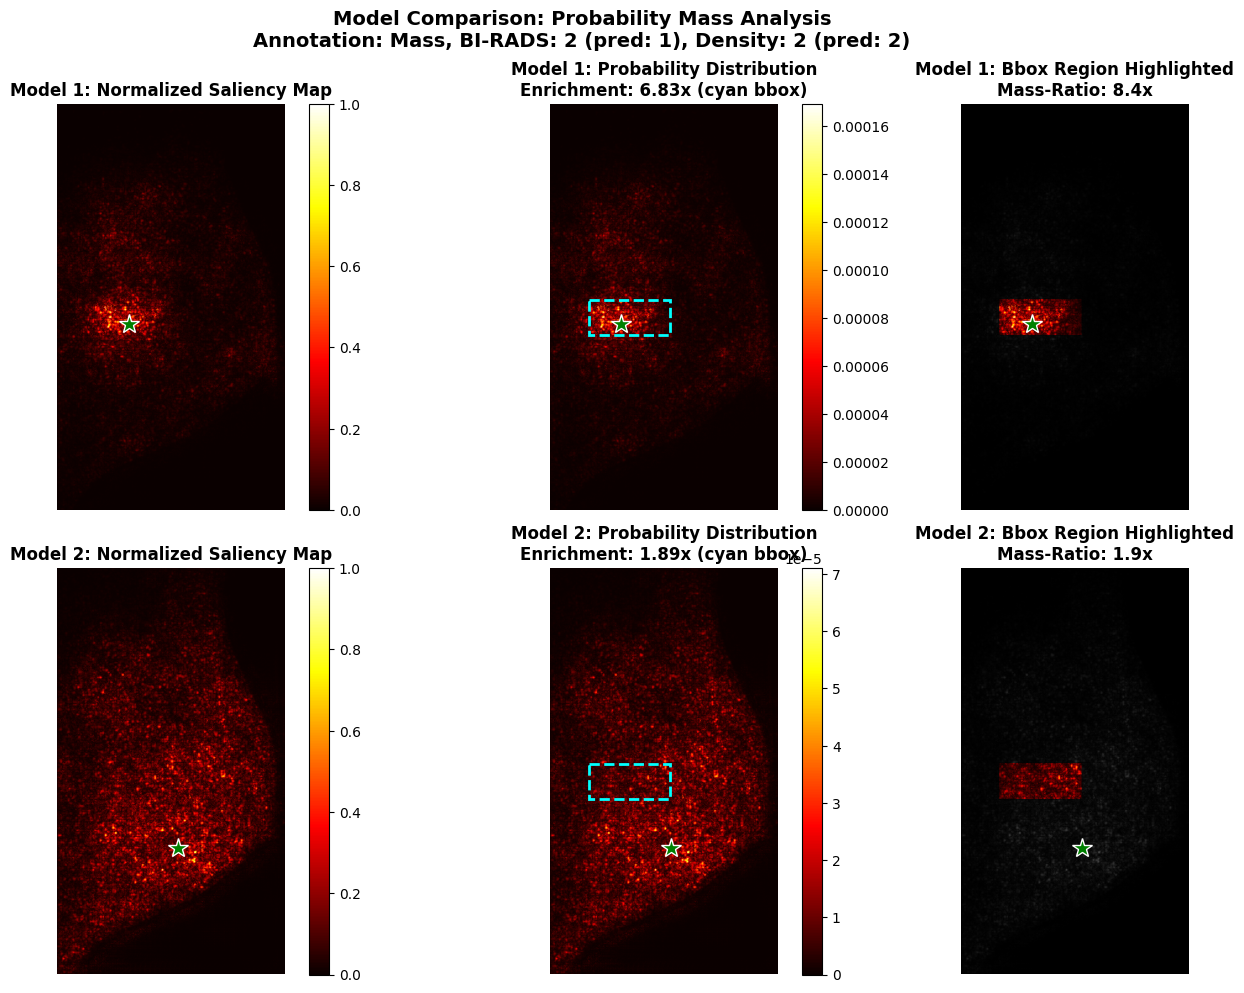

In [98]:
_ = plot_probability_mass_comparison(model, model_dens, breast_loader.test_dataset, annot_test.iloc[3], cancer_individual_first_loadings, dens_individual_first_loadings)

In [81]:
results_cancer1indiv = process_all_annotations_ajive(model, breast_loader.test_dataset, annot_test, cancer_individual_first_loadings)

Processing annotations:   0%|          | 0/488 [00:00<?, ?it/s]

In [82]:
results_dens1indiv = process_all_annotations_ajive(model_dens, breast_loader.test_dataset, annot_test, dens_individual_first_loadings)

Processing annotations:   0%|          | 0/488 [00:00<?, ?it/s]

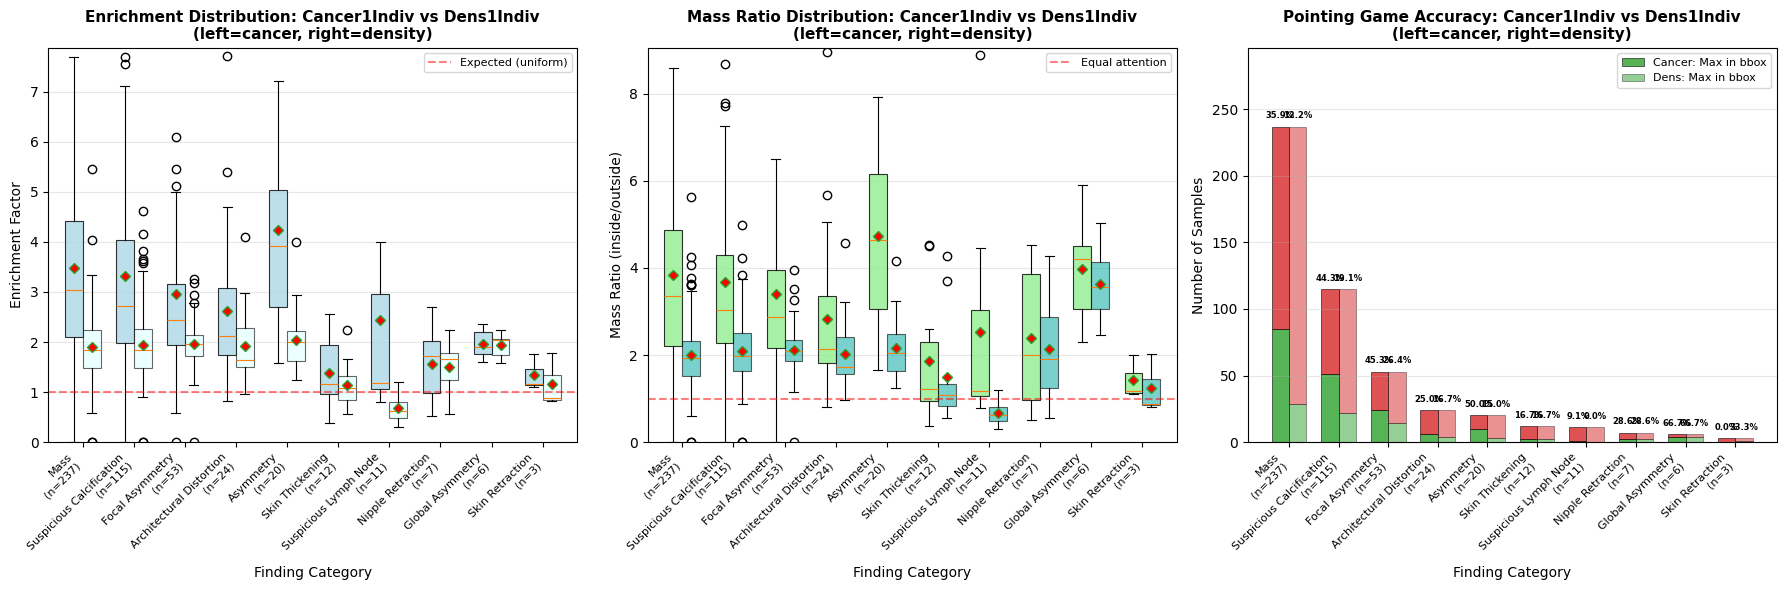

In [100]:
if 1:
    # Create comprehensive visualization comparing cancer1indiv vs dens1indiv 
    # using ALL categories and ALL samples (no filtering, no BI-RADS stratification)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Sort categories by total count from cancer1indiv
    category_order = results_cancer1indiv['finding_category'].value_counts(ascending=False).index
    
    # Create labels with sample counts
    category_labels_cancer = [f"{cat}\n(n={len(results_cancer1indiv[results_cancer1indiv['finding_category'] == cat])})" 
                             for cat in category_order]
    category_labels_dens = [f"{cat}\n(n={len(results_dens1indiv[results_dens1indiv['finding_category'] == cat])})" 
                           for cat in category_order]
    
    # 1. Enrichment distribution - dual boxplots
    ax = axes[0]
    enrichment_data_cancer = [results_cancer1indiv[results_cancer1indiv['finding_category'] == cat]['enrichment'].values 
                             for cat in category_order]
    enrichment_data_dens = [results_dens1indiv[results_dens1indiv['finding_category'] == cat]['enrichment'].values 
                           for cat in category_order]
    
    x_positions = np.arange(len(category_order))
    box_width = 0.35
    
    bp_cancer = ax.boxplot(enrichment_data_cancer, positions=x_positions - box_width/2, widths=box_width,
                           patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                           boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                           capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    bp_dens = ax.boxplot(enrichment_data_dens, positions=x_positions + box_width/2, widths=box_width,
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                        boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                        capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    
    # Color the boxes
    for patch in bp_cancer['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.8)
    
    for patch in bp_dens['boxes']:
        patch.set_facecolor('lightcyan')
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Enrichment Distribution: Cancer1Indiv vs Dens1Indiv\n(left=cancer, right=density)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected (uniform)')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(category_labels_cancer, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_enrichment_cancer = results_cancer1indiv['enrichment'].quantile(0.95)
    max_enrichment_dens = results_dens1indiv['enrichment'].quantile(0.95)
    max_enrichment = max(max_enrichment_cancer, max_enrichment_dens)
    ax.set_ylim(0, max_enrichment * 1.15)
    
    # 2. Mass ratio distribution - dual boxplots
    ax = axes[1]
    mass_ratio_data_cancer = [results_cancer1indiv[results_cancer1indiv['finding_category'] == cat]['mass_ratio'].values 
                             for cat in category_order]
    mass_ratio_data_dens = [results_dens1indiv[results_dens1indiv['finding_category'] == cat]['mass_ratio'].values 
                           for cat in category_order]
    
    bp_cancer = ax.boxplot(mass_ratio_data_cancer, positions=x_positions - box_width/2, widths=box_width,
                           patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                           boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                           capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    bp_dens = ax.boxplot(mass_ratio_data_dens, positions=x_positions + box_width/2, widths=box_width,
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                        boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                        capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    
    # Color the boxes
    for patch in bp_cancer['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.8)
    
    for patch in bp_dens['boxes']:
        patch.set_facecolor('lightseagreen')
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Mass Ratio Distribution: Cancer1Indiv vs Dens1Indiv\n(left=cancer, right=density)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal attention')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(category_labels_cancer, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_mass_ratio_cancer = results_cancer1indiv['mass_ratio'].quantile(0.95)
    max_mass_ratio_dens = results_dens1indiv['mass_ratio'].quantile(0.95)
    max_mass_ratio = max(max_mass_ratio_cancer, max_mass_ratio_dens)
    ax.set_ylim(0, max_mass_ratio * 1.15)
    
    # 3. Pointing Game accuracy - grouped bars
    ax = axes[2]
    pointing_stats_cancer = results_cancer1indiv.groupby('finding_category')['pointing_game'].agg(['mean', 'sum', 'count'])
    pointing_stats_cancer = pointing_stats_cancer.loc[category_order]
    pointing_stats_dens = results_dens1indiv.groupby('finding_category')['pointing_game'].agg(['mean', 'sum', 'count'])
    pointing_stats_dens = pointing_stats_dens.loc[category_order]
    
    # Prepare bar data
    success_cancer = pointing_stats_cancer['sum'].values
    total_cancer = pointing_stats_cancer['count'].values
    failure_cancer = total_cancer - success_cancer
    
    success_dens = pointing_stats_dens['sum'].values
    total_dens = pointing_stats_dens['count'].values
    failure_dens = total_dens - success_dens
    
    # Plot grouped stacked bars
    x_pos_cancer = x_positions - box_width/2
    x_pos_dens = x_positions + box_width/2
    
    ax.bar(x_pos_cancer, success_cancer, width=box_width, color='#2ca02c', alpha=0.8, 
          label='Cancer: Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos_cancer, failure_cancer, width=box_width, bottom=success_cancer, color='#d62728', alpha=0.8, 
          edgecolor='black', linewidth=0.5)
    
    ax.bar(x_pos_dens, success_dens, width=box_width, color='#2ca02c', alpha=0.5, 
          label='Dens: Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos_dens, failure_dens, width=box_width, bottom=success_dens, color='#d62728', alpha=0.5, 
          edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(category_labels_cancer, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Pointing Game Accuracy: Cancer1Indiv vs Dens1Indiv\n(left=cancer, right=density)', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_total = max(total_cancer.max(), total_dens.max())
    ax.set_ylim(0, max_total * 1.25)
    
    # Add percentage labels on top of bars
    for i, cat in enumerate(category_order):
        acc_c = pointing_stats_cancer.loc[cat, 'mean']
        total_c = pointing_stats_cancer.loc[cat, 'count']
        ax.text(x_pos_cancer[i], total_c + max_total * 0.02, f"{acc_c:.1%}", 
               ha='center', va='bottom', fontsize=6, fontweight='bold')
        
        acc_d = pointing_stats_dens.loc[cat, 'mean']
        total_d = pointing_stats_dens.loc[cat, 'count']
        ax.text(x_pos_dens[i], total_d + max_total * 0.02, f"{acc_d:.1%}", 
               ha='center', va='bottom', fontsize=6, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


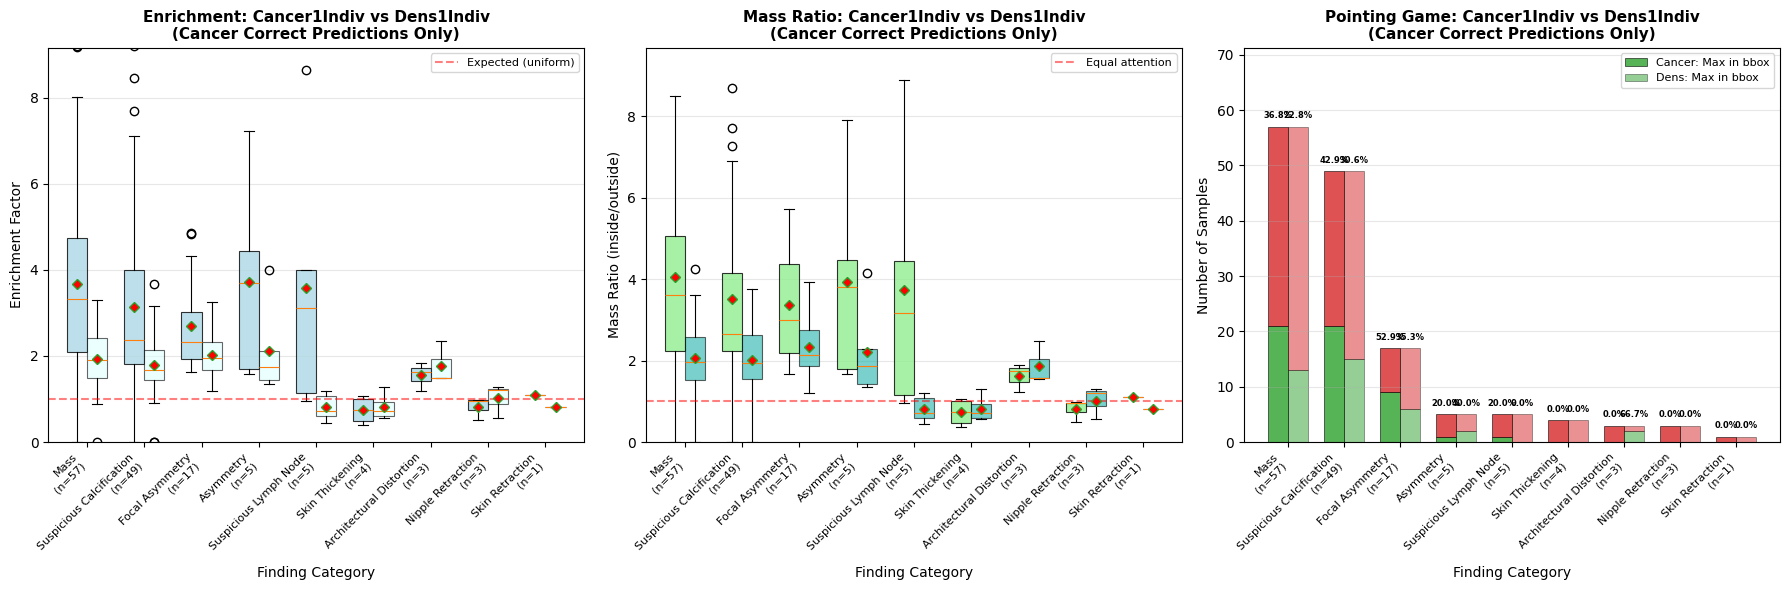

In [101]:
if 1:
    # Create visualization comparing cancer1indiv vs dens1indiv 
    # for samples CORRECTLY CLASSIFIED by cancer network only
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Filter cancer dataset to correctly predicted samples
    results_cancer1indiv_correct_filt = results_cancer1indiv[
        results_cancer1indiv['BI-RADS'] == results_cancer1indiv['predicted_class']
    ].copy()
    
    # Get the indices of correctly classified cancer samples
    correct_indices = results_cancer1indiv_correct_filt.index
    
    # Filter density dataset to include only the same samples
    results_dens1indiv_correct_filt = results_dens1indiv.loc[correct_indices].copy()
    
    # Sort categories by total count from filtered cancer dataset
    category_order = results_cancer1indiv_correct_filt['finding_category'].value_counts(ascending=False).index
    
    # Create labels with sample counts
    category_labels = [f"{cat}\n(n={len(results_cancer1indiv_correct_filt[results_cancer1indiv_correct_filt['finding_category'] == cat])})" 
                      for cat in category_order]
    
    # 1. Enrichment distribution - dual boxplots
    ax = axes[0]
    enrichment_data_cancer = [results_cancer1indiv_correct_filt[results_cancer1indiv_correct_filt['finding_category'] == cat]['enrichment'].values 
                             for cat in category_order]
    enrichment_data_dens = [results_dens1indiv_correct_filt[results_dens1indiv_correct_filt['finding_category'] == cat]['enrichment'].values 
                           for cat in category_order]
    
    x_positions = np.arange(len(category_order))
    box_width = 0.35
    
    bp_cancer = ax.boxplot(enrichment_data_cancer, positions=x_positions - box_width/2, widths=box_width,
                           patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                           boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                           capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    bp_dens = ax.boxplot(enrichment_data_dens, positions=x_positions + box_width/2, widths=box_width,
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                        boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                        capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    
    # Color the boxes
    for patch in bp_cancer['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.8)
    
    for patch in bp_dens['boxes']:
        patch.set_facecolor('lightcyan')
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Enrichment: Cancer1Indiv vs Dens1Indiv\n(Cancer Correct Predictions Only)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected (uniform)')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_enrichment_cancer = results_cancer1indiv_correct_filt['enrichment'].quantile(0.95)
    max_enrichment_dens = results_dens1indiv_correct_filt['enrichment'].quantile(0.95)
    max_enrichment = max(max_enrichment_cancer, max_enrichment_dens)
    ax.set_ylim(0, max_enrichment * 1.15)
    
    # 2. Mass ratio distribution - dual boxplots
    ax = axes[1]
    mass_ratio_data_cancer = [results_cancer1indiv_correct_filt[results_cancer1indiv_correct_filt['finding_category'] == cat]['mass_ratio'].values 
                             for cat in category_order]
    mass_ratio_data_dens = [results_dens1indiv_correct_filt[results_dens1indiv_correct_filt['finding_category'] == cat]['mass_ratio'].values 
                           for cat in category_order]
    
    bp_cancer = ax.boxplot(mass_ratio_data_cancer, positions=x_positions - box_width/2, widths=box_width,
                           patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                           boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                           capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    bp_dens = ax.boxplot(mass_ratio_data_dens, positions=x_positions + box_width/2, widths=box_width,
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=5),
                        boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                        capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    
    # Color the boxes
    for patch in bp_cancer['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.8)
    
    for patch in bp_dens['boxes']:
        patch.set_facecolor('lightseagreen')
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Mass Ratio: Cancer1Indiv vs Dens1Indiv\n(Cancer Correct Predictions Only)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal attention')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_mass_ratio_cancer = results_cancer1indiv_correct_filt['mass_ratio'].quantile(0.95)
    max_mass_ratio_dens = results_dens1indiv_correct_filt['mass_ratio'].quantile(0.95)
    max_mass_ratio = max(max_mass_ratio_cancer, max_mass_ratio_dens)
    ax.set_ylim(0, max_mass_ratio * 1.15)
    
    # 3. Pointing Game accuracy - grouped bars
    ax = axes[2]
    pointing_stats_cancer = results_cancer1indiv_correct_filt.groupby('finding_category')['pointing_game'].agg(['mean', 'sum', 'count'])
    pointing_stats_cancer = pointing_stats_cancer.loc[category_order]
    pointing_stats_dens = results_dens1indiv_correct_filt.groupby('finding_category')['pointing_game'].agg(['mean', 'sum', 'count'])
    pointing_stats_dens = pointing_stats_dens.loc[category_order]
    
    # Prepare bar data
    success_cancer = pointing_stats_cancer['sum'].values
    total_cancer = pointing_stats_cancer['count'].values
    failure_cancer = total_cancer - success_cancer
    
    success_dens = pointing_stats_dens['sum'].values
    total_dens = pointing_stats_dens['count'].values
    failure_dens = total_dens - success_dens
    
    # Plot grouped stacked bars
    x_pos_cancer = x_positions - box_width/2
    x_pos_dens = x_positions + box_width/2
    
    ax.bar(x_pos_cancer, success_cancer, width=box_width, color='#2ca02c', alpha=0.8, 
          label='Cancer: Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos_cancer, failure_cancer, width=box_width, bottom=success_cancer, color='#d62728', alpha=0.8, 
          edgecolor='black', linewidth=0.5)
    
    ax.bar(x_pos_dens, success_dens, width=box_width, color='#2ca02c', alpha=0.5, 
          label='Dens: Max in bbox', edgecolor='black', linewidth=0.5)
    ax.bar(x_pos_dens, failure_dens, width=box_width, bottom=success_dens, color='#d62728', alpha=0.5, 
          edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_xlabel('Finding Category', fontsize=10)
    ax.set_title('Pointing Game: Cancer1Indiv vs Dens1Indiv\n(Cancer Correct Predictions Only)', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_total = max(total_cancer.max(), total_dens.max())
    ax.set_ylim(0, max_total * 1.25)
    
    # Add percentage labels on top of bars
    for i, cat in enumerate(category_order):
        acc_c = pointing_stats_cancer.loc[cat, 'mean']
        total_c = pointing_stats_cancer.loc[cat, 'count']
        ax.text(x_pos_cancer[i], total_c + max_total * 0.02, f"{acc_c:.1%}", 
               ha='center', va='bottom', fontsize=6, fontweight='bold')
        
        acc_d = pointing_stats_dens.loc[cat, 'mean']
        total_d = pointing_stats_dens.loc[cat, 'count']
        ax.text(x_pos_dens[i], total_d + max_total * 0.02, f"{acc_d:.1%}", 
               ha='center', va='bottom', fontsize=6, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


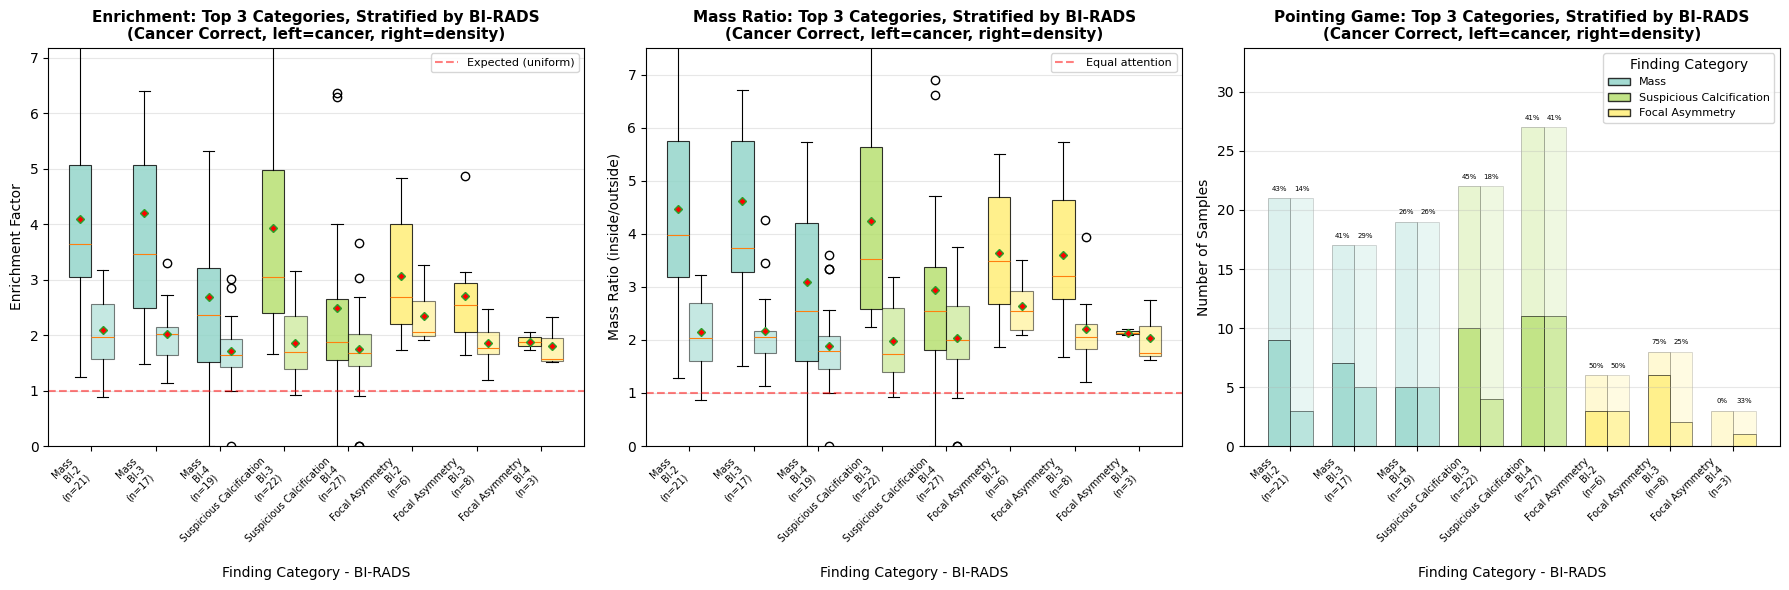

In [102]:
if 1:
    # Create BI-RADS stratified visualization comparing cancer1indiv vs dens1indiv
    # Top 3 categories, correctly classified by cancer network, stratified by BI-RADS
    
    # Filter cancer dataset to correctly predicted samples
    results_cancer1indiv_correct_top3_filt = results_cancer1indiv[
        results_cancer1indiv['BI-RADS'] == results_cancer1indiv['predicted_class']
    ].copy()
    
    # Get the indices of correctly classified cancer samples
    correct_indices_top3 = results_cancer1indiv_correct_top3_filt.index
    
    # Filter density dataset to include only the same samples
    results_dens1indiv_correct_top3_filt = results_dens1indiv.loc[correct_indices_top3].copy()
    
    # Get top 3 finding categories by sample count from filtered cancer dataset
    top_3_categories = results_cancer1indiv_correct_top3_filt['finding_category'].value_counts().head(3).index.tolist()
    
    # Filter both datasets to top 3 categories
    results_cancer1indiv_top3_stratified = results_cancer1indiv_correct_top3_filt[
        results_cancer1indiv_correct_top3_filt['finding_category'].isin(top_3_categories)
    ]
    results_dens1indiv_top3_stratified = results_dens1indiv_correct_top3_filt[
        results_dens1indiv_correct_top3_filt['finding_category'].isin(top_3_categories)
    ]
    
    # Get all BI-RADS values present
    birads_values = sorted(results_cancer1indiv_top3_stratified['BI-RADS'].unique())
    
    # Create color palette for categories
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_3_categories)))
    category_colors = {cat: colors[i] for i, cat in enumerate(top_3_categories)}
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Prepare data structures
    categories_and_birads = []
    enrichment_data_cancer = []
    enrichment_data_dens = []
    mass_ratio_data_cancer = []
    mass_ratio_data_dens = []
    pointing_game_data_cancer = []
    pointing_game_data_dens = []
    box_category_mapping = []
    
    for cat in top_3_categories:
        for birads in birads_values:
            subset_cancer = results_cancer1indiv_top3_stratified[
                (results_cancer1indiv_top3_stratified['finding_category'] == cat) & 
                (results_cancer1indiv_top3_stratified['BI-RADS'] == birads)
            ]
            subset_dens = results_dens1indiv_top3_stratified[
                (results_dens1indiv_top3_stratified['finding_category'] == cat) & 
                (results_dens1indiv_top3_stratified['BI-RADS'] == birads)
            ]
            if len(subset_cancer) > 0:
                categories_and_birads.append(f"{cat}\nBI-{birads}\n(n={len(subset_cancer)})")
                enrichment_data_cancer.append(subset_cancer['enrichment'].values)
                enrichment_data_dens.append(subset_dens['enrichment'].values)
                mass_ratio_data_cancer.append(subset_cancer['mass_ratio'].values)
                mass_ratio_data_dens.append(subset_dens['mass_ratio'].values)
                pointing_game_data_cancer.append(subset_cancer['pointing_game'].values)
                pointing_game_data_dens.append(subset_dens['pointing_game'].values)
                box_category_mapping.append(cat)
    
    # 1. Enrichment distribution - dual boxplots
    ax = axes[0]
    x_positions = np.arange(len(categories_and_birads))
    box_width = 0.35
    
    bp_cancer = ax.boxplot(enrichment_data_cancer, positions=x_positions - box_width/2, widths=box_width,
                           patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=4),
                           boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                           capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    bp_dens = ax.boxplot(enrichment_data_dens, positions=x_positions + box_width/2, widths=box_width,
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=4),
                        boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                        capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    
    # Color the boxes by category
    for i, patch in enumerate(bp_cancer['boxes']):
        cat = box_category_mapping[i]
        patch.set_facecolor(category_colors[cat])
        patch.set_alpha(0.8)
    
    for i, patch in enumerate(bp_dens['boxes']):
        cat = box_category_mapping[i]
        patch.set_facecolor(category_colors[cat])
        patch.set_alpha(0.5)
    
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_xlabel('Finding Category - BI-RADS', fontsize=10)
    ax.set_title('Enrichment: Top 3 Categories, Stratified by BI-RADS\n(Cancer Correct, left=cancer, right=density)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected (uniform)')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories_and_birads, rotation=45, ha='right', fontsize=7)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    all_enrichment = np.concatenate(enrichment_data_cancer + enrichment_data_dens)
    max_enrichment = np.percentile(all_enrichment, 95) if len(all_enrichment) > 0 else 1
    ax.set_ylim(0, max_enrichment * 1.15)
    
    # 2. Mass ratio distribution - dual boxplots
    ax = axes[1]
    
    bp_cancer = ax.boxplot(mass_ratio_data_cancer, positions=x_positions - box_width/2, widths=box_width,
                           patch_artist=True, showmeans=True,
                           meanprops=dict(marker='D', markerfacecolor='red', markersize=4),
                           boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                           capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    bp_dens = ax.boxplot(mass_ratio_data_dens, positions=x_positions + box_width/2, widths=box_width,
                        patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=4),
                        boxprops=dict(linewidth=0.8), whiskerprops=dict(linewidth=0.8),
                        capprops=dict(linewidth=0.8), medianprops=dict(linewidth=0.8))
    
    # Color the boxes by category
    for i, patch in enumerate(bp_cancer['boxes']):
        cat = box_category_mapping[i]
        patch.set_facecolor(category_colors[cat])
        patch.set_alpha(0.8)
    
    for i, patch in enumerate(bp_dens['boxes']):
        cat = box_category_mapping[i]
        patch.set_facecolor(category_colors[cat])
        patch.set_alpha(0.5)
    
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_xlabel('Finding Category - BI-RADS', fontsize=10)
    ax.set_title('Mass Ratio: Top 3 Categories, Stratified by BI-RADS\n(Cancer Correct, left=cancer, right=density)', 
                fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal attention')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories_and_birads, rotation=45, ha='right', fontsize=7)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    all_mass_ratio = np.concatenate(mass_ratio_data_cancer + mass_ratio_data_dens)
    max_mass_ratio = np.percentile(all_mass_ratio, 95) if len(all_mass_ratio) > 0 else 1
    ax.set_ylim(0, max_mass_ratio * 1.15)
    
    # 3. Pointing Game accuracy - grouped bars
    ax = axes[2]
    
    success_cancer = []
    total_cancer = []
    success_dens = []
    total_dens = []
    
    for data_c, data_d in zip(pointing_game_data_cancer, pointing_game_data_dens):
        success_cancer.append(np.sum(data_c))
        total_cancer.append(len(data_c))
        success_dens.append(np.sum(data_d))
        total_dens.append(len(data_d))
    
    failure_cancer = [t - s for t, s in zip(total_cancer, success_cancer)]
    failure_dens = [t - s for t, s in zip(total_dens, success_dens)]
    
    # Plot grouped bars
    x_pos_cancer = x_positions - box_width/2
    x_pos_dens = x_positions + box_width/2
    
    for i in range(len(x_positions)):
        cat = box_category_mapping[i]
        color = category_colors[cat]
        
        # Cancer bars
        ax.bar(x_pos_cancer[i], success_cancer[i], width=box_width, color=color, alpha=0.8, 
              edgecolor='black', linewidth=0.5)
        ax.bar(x_pos_cancer[i], failure_cancer[i], width=box_width, bottom=success_cancer[i], 
              color=color, alpha=0.3, edgecolor='black', linewidth=0.5)
        
        # Dens bars
        ax.bar(x_pos_dens[i], success_dens[i], width=box_width, color=color, alpha=0.6, 
              edgecolor='black', linewidth=0.5)
        ax.bar(x_pos_dens[i], failure_dens[i], width=box_width, bottom=success_dens[i], 
              color=color, alpha=0.2, edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories_and_birads, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel('Number of Samples', fontsize=10)
    ax.set_xlabel('Finding Category - BI-RADS', fontsize=10)
    ax.set_title('Pointing Game: Top 3 Categories, Stratified by BI-RADS\n(Cancer Correct, left=cancer, right=density)', 
                fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Set reasonable y-axis limits
    max_total = max(max(total_cancer), max(total_dens)) if total_cancer and total_dens else 1
    ax.set_ylim(0, max_total * 1.25)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=category_colors[cat], alpha=0.8, edgecolor='black', label=cat)
                       for cat in top_3_categories]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8, title='Finding Category')
    
    # Add percentage labels on pointing game bars
    for i in range(len(x_positions)):
        if total_cancer[i] > 0:
            acc_c = success_cancer[i] / total_cancer[i]
            ax.text(x_pos_cancer[i], total_cancer[i] + max_total * 0.02, 
                   f"{acc_c:.0%}", ha='center', va='bottom', fontsize=5)
        
        if total_dens[i] > 0:
            acc_d = success_dens[i] / total_dens[i]
            ax.text(x_pos_dens[i], total_dens[i] + max_total * 0.02, 
                   f"{acc_d:.0%}", ha='center', va='bottom', fontsize=5)
    
    plt.tight_layout()
    plt.show()


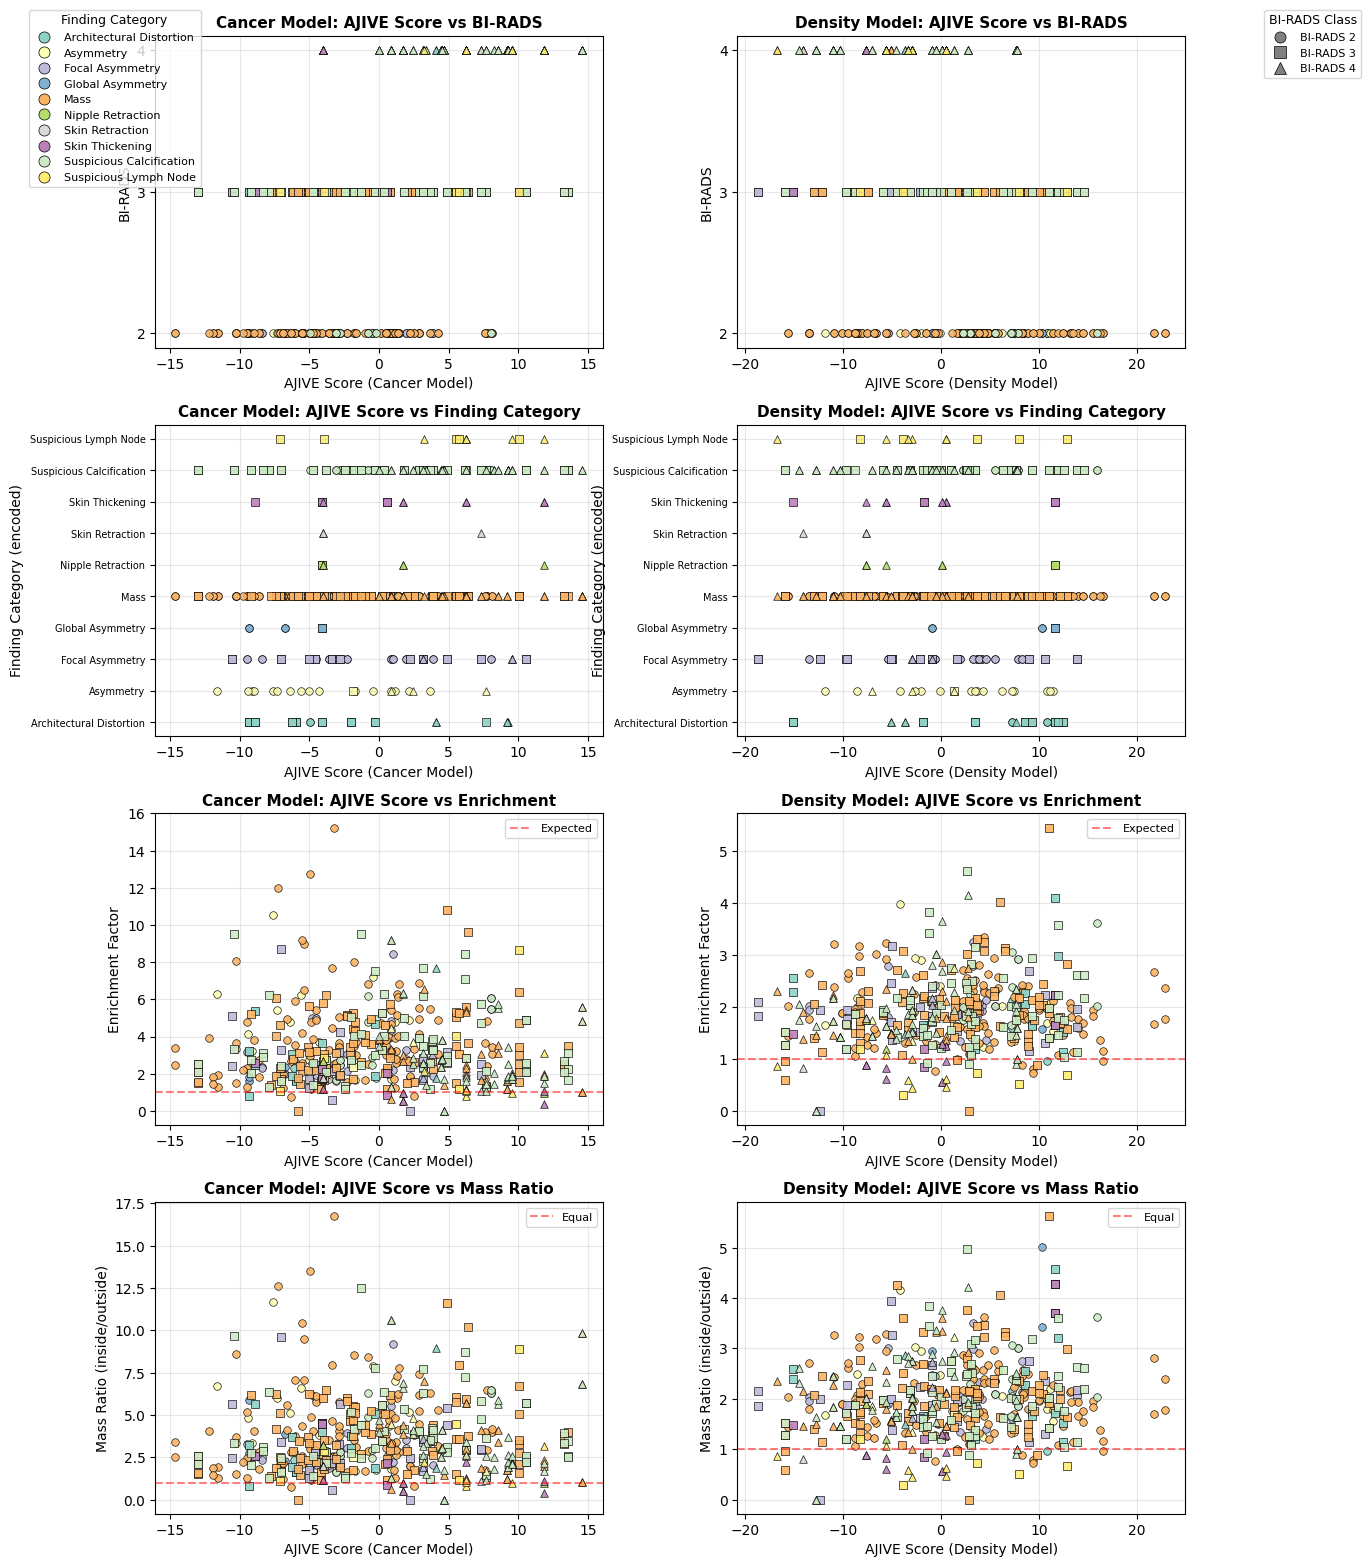

In [106]:
if 1:
    # Create scatterplot matrix showing ajive_score vs various metrics
    # Left column: Cancer model, Right column: Density model
    
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    
    # Numerize finding categories for both datasets
    # Create a consistent mapping across both datasets
    all_categories = pd.concat([
        results_cancer1indiv['finding_category'],
        results_dens1indiv['finding_category']
    ]).unique()
    category_to_num = {cat: i for i, cat in enumerate(sorted(all_categories))}
    
    results_cancer1indiv['finding_category_num'] = results_cancer1indiv['finding_category'].map(category_to_num)
    results_dens1indiv['finding_category_num'] = results_dens1indiv['finding_category'].map(category_to_num)
    
    # Create color mapping for finding categories
    unique_categories = sorted(all_categories)
    category_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
    category_color_map = {cat: category_colors[i] for i, cat in enumerate(unique_categories)}
    
    # Create marker mapping for BI-RADS classes
    birads_markers = {2: 'o', 3: 's', 4: '^', 5: 'D', 6: 'v'}
    
    # ============== CANCER MODEL (Left Column) ==============
    
    # Row 0: ajive_score vs BI-RADS
    ax = axes[0, 0]
    for birads in sorted(results_cancer1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_cancer1indiv['BI-RADS'] == birads) & (results_cancer1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_cancer1indiv.loc[mask, 'ajive_score'], 
                          results_cancer1indiv.loc[mask, 'BI-RADS'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5,
                          label=f'{category[:15]}... BI-{birads}' if len(mask) > 0 else None)
    ax.set_xlabel('AJIVE Score (Cancer Model)', fontsize=10)
    ax.set_ylabel('BI-RADS', fontsize=10)
    ax.set_title('Cancer Model: AJIVE Score vs BI-RADS', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yticks(sorted(results_cancer1indiv['BI-RADS'].unique()))
    
    # Row 1: ajive_score vs finding_category (numerized)
    ax = axes[1, 0]
    for birads in sorted(results_cancer1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_cancer1indiv['BI-RADS'] == birads) & (results_cancer1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_cancer1indiv.loc[mask, 'ajive_score'], 
                          results_cancer1indiv.loc[mask, 'finding_category_num'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Cancer Model)', fontsize=10)
    ax.set_ylabel('Finding Category (encoded)', fontsize=10)
    ax.set_title('Cancer Model: AJIVE Score vs Finding Category', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    # Set y-ticks and labels
    unique_cats = sorted(results_cancer1indiv['finding_category'].unique())
    y_ticks = [category_to_num[cat] for cat in unique_cats]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(unique_cats, fontsize=7)
    
    # Row 2: ajive_score vs enrichment
    ax = axes[2, 0]
    for birads in sorted(results_cancer1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_cancer1indiv['BI-RADS'] == birads) & (results_cancer1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_cancer1indiv.loc[mask, 'ajive_score'], 
                          results_cancer1indiv.loc[mask, 'enrichment'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Cancer Model)', fontsize=10)
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_title('Cancer Model: AJIVE Score vs Enrichment', fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Row 3: ajive_score vs mass_ratio
    ax = axes[3, 0]
    for birads in sorted(results_cancer1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_cancer1indiv['BI-RADS'] == birads) & (results_cancer1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_cancer1indiv.loc[mask, 'ajive_score'], 
                          results_cancer1indiv.loc[mask, 'mass_ratio'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Cancer Model)', fontsize=10)
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_title('Cancer Model: AJIVE Score vs Mass Ratio', fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # ============== DENSITY MODEL (Right Column) ==============
    
    # Row 0: ajive_score vs BI-RADS
    ax = axes[0, 1]
    for birads in sorted(results_dens1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_dens1indiv['BI-RADS'] == birads) & (results_dens1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_dens1indiv.loc[mask, 'ajive_score'], 
                          results_dens1indiv.loc[mask, 'BI-RADS'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Density Model)', fontsize=10)
    ax.set_ylabel('BI-RADS', fontsize=10)
    ax.set_title('Density Model: AJIVE Score vs BI-RADS', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yticks(sorted(results_dens1indiv['BI-RADS'].unique()))
    
    # Row 1: ajive_score vs finding_category (numerized)
    ax = axes[1, 1]
    for birads in sorted(results_dens1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_dens1indiv['BI-RADS'] == birads) & (results_dens1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_dens1indiv.loc[mask, 'ajive_score'], 
                          results_dens1indiv.loc[mask, 'finding_category_num'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Density Model)', fontsize=10)
    ax.set_ylabel('Finding Category (encoded)', fontsize=10)
    ax.set_title('Density Model: AJIVE Score vs Finding Category', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    # Set y-ticks and labels
    unique_cats = sorted(results_dens1indiv['finding_category'].unique())
    y_ticks = [category_to_num[cat] for cat in unique_cats]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(unique_cats, fontsize=7)
    
    # Row 2: ajive_score vs enrichment
    ax = axes[2, 1]
    for birads in sorted(results_dens1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_dens1indiv['BI-RADS'] == birads) & (results_dens1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_dens1indiv.loc[mask, 'ajive_score'], 
                          results_dens1indiv.loc[mask, 'enrichment'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Density Model)', fontsize=10)
    ax.set_ylabel('Enrichment Factor', fontsize=10)
    ax.set_title('Density Model: AJIVE Score vs Enrichment', fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Expected')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Row 3: ajive_score vs mass_ratio
    ax = axes[3, 1]
    for birads in sorted(results_dens1indiv['BI-RADS'].unique()):
        for category in unique_categories:
            mask = (results_dens1indiv['BI-RADS'] == birads) & (results_dens1indiv['finding_category'] == category)
            if mask.any():
                ax.scatter(results_dens1indiv.loc[mask, 'ajive_score'], 
                          results_dens1indiv.loc[mask, 'mass_ratio'],
                          alpha=0.9, s=30, 
                          c=[category_color_map[category]], 
                          marker=birads_markers.get(birads, 'o'),
                          edgecolors='black', linewidths=0.5)
    ax.set_xlabel('AJIVE Score (Density Model)', fontsize=10)
    ax.set_ylabel('Mass Ratio (inside/outside)', fontsize=10)
    ax.set_title('Density Model: AJIVE Score vs Mass Ratio', fontsize=11, fontweight='bold')
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Equal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Create custom legends
    # Category legend (colors)
    category_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=category_color_map[cat], 
                                   markersize=8, label=cat, markeredgecolor='black', markeredgewidth=0.5)
                       for cat in unique_categories]
    
    # BI-RADS legend (markers)
    birads_handles = [plt.Line2D([0], [0], marker=birads_markers.get(birads, 'o'), color='w', 
                                 markerfacecolor='gray', markersize=8, 
                                 label=f'BI-RADS {birads}', markeredgecolor='black', markeredgewidth=0.5)
                     for birads in sorted(set(list(results_cancer1indiv['BI-RADS'].unique()) + 
                                             list(results_dens1indiv['BI-RADS'].unique())))]
    
    # Add legends outside the plot area
    fig.legend(handles=category_handles, loc='upper left', bbox_to_anchor=(0.02, 0.98), 
               title='Finding Category', fontsize=8, title_fontsize=9, ncol=1)
    fig.legend(handles=birads_handles, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
               title='BI-RADS Class', fontsize=8, title_fontsize=9, ncol=1)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.96, right=0.85)
    plt.show()
